In [1]:
# Use LSTM to predict stock price

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("Current device is mps")

Current device is mps


# Import and preprocess dataset

In [4]:
import pandas_datareader.data as web
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2022, 10, 30)
df = web.DataReader("GOOGL", "stooq", start, end)

In [5]:
df.sort_index(inplace = True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
...,...,...,...,...,...
2022-10-24,101.80000,102.7500,99.98000,102.52000,27176417.0
2022-10-25,102.90000,104.8200,102.72000,104.48000,40611375.0
2022-10-26,96.43000,98.3100,94.69000,94.93000,88279042.0


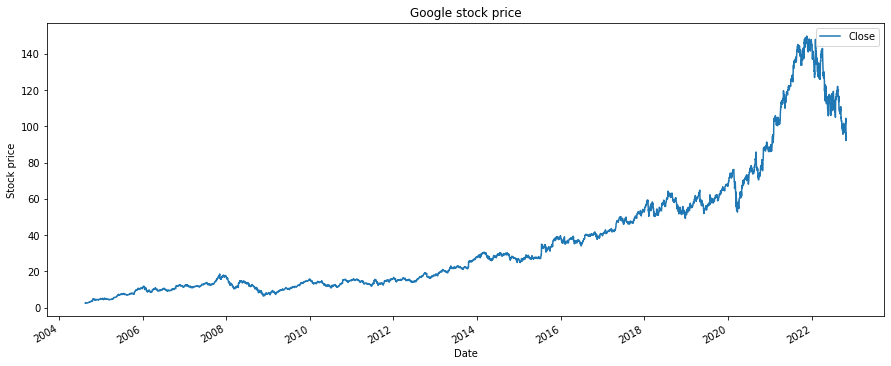

In [6]:
df[["Close"]].plot(figsize=(15,6))
plt.ylabel("Stock price")
plt.title("Google stock price")
plt.show()

In [7]:
df.describe()

,Open,High,Low,Close,Volume
count,4582.000000,4582.000000,4582.000000,4582.000000,4.581000e+03
mean,37.234385,37.610194,36.843978,37.234463,1.253231e+08
std,34.741803,35.113070,34.358235,34.741340,1.525965e+08
min,2.479750,2.543500,2.399000,2.500250,9.312760e+06
25%,12.571250,12.713875,12.433750,12.574250,3.263714e+07
50%,22.586000,22.750250,22.432250,22.601250,7.126800e+07
75%,53.346875,53.997750,52.725750,53.481125,1.552240e+08
max,151.250000,151.547000,148.899000,149.838000,1.644668e+09


In [8]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    1
dtype: int64

In [9]:
df.dropna(inplace=True, axis=0)

In [10]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
...,...,...,...,...,...
2022-10-24,101.80000,102.7500,99.98000,102.52000,27176417.0
2022-10-25,102.90000,104.8200,102.72000,104.48000,40611375.0
2022-10-26,96.43000,98.3100,94.69000,94.93000,88279042.0


## Scale the feature

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

df["Close"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

## Split the data

In [12]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    X_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    X_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    
    return [X_train, y_train, X_test, y_test]

look_back = 10 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df[["Close"]], look_back)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (3657, 9, 1)
y_train.shape = (3657, 1)
x_test.shape = (914, 9, 1)
y_test.shape = (914, 1)


In [13]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

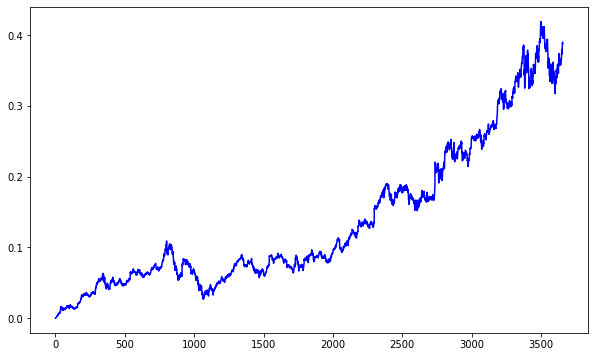

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.numpy(), color = "blue")
# plt.plot(x_train.numpy()[:,-1,:], color = "red")
plt.show()

## Define key functions

In [15]:
def train_model(model, criterion = "MSE", optimiser = "Adam", learning_rate = 0.01, epochs = 200, verbose = 1):
    if criterion == "MSE":
        criterion = torch.nn.MSELoss(reduction="mean")
    if optimiser == "Adam":
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimiser == "SGD":
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
    loss_history = np.zeros(epochs)

    
    for e in range(epochs):
        y_train_pred = model(x_train)[0]
        loss = criterion(y_train_pred[:,-1,:], y_train) 
        # loss = criterion(y_train_pred, y_train)             
        loss_history[e] = loss.item()
        

        if e % 10 == 0 and e > 0:
            if verbose == 1:
                print("Epoch:", e, "MSE:", loss.item())
            else:
                pass
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model, loss_history#, accuracy_history

In [16]:
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history)
    plt.xlabel("Training epochs")
    plt.ylabel("MSE loss")
    plt.title("Training MSE Loss")
    plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
import math

def plot_prediction(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    y_train_pred = model(x_train)[0][:,-1,:].detach().numpy()
    y_test_pred = model(x_test)[0][:,-1,:].detach().numpy()
    # y_train_pred = model(x_train)[0].detach().numpy()
    # y_test_pred = model(x_test)[0].detach().numpy()
    
    plt.figure(figsize=(30,10))
    plt.subplot(1,2,1)
    plt.plot(y_train_pred, color = "red", label = "Train prediction")
    plt.plot(y_train, color = "blue", label = "Train true values")
    plt.legend()
    plt.title("Training set")
    
    plt.subplot(1,2,2)
    plt.plot(y_test_pred, color = "red", label = "Test prediction")
    plt.plot(y_test, color = "blue", label = "Test true values")
    plt.legend()
    plt.title("Testing set")  
    
    # invert predictions
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))


# Baseline RNN model

Input size: Number of feature dimensions (e.g., number of data channels). Often set to 1

Sequence length: Length of data snippet used for learning.

Batch size: Number of sequences to input per epoch.

Hidden size: Number of units in the hidden layer.

Number of layers: Number of hidden layers stacked on each other.

In [18]:
# set layer parameters
input_size = 1 
hidden_size = 64
num_layers = 1

The hidden state should be initialized to zeros at the start of each sequence. Otherwise the model starts learning the sequence biased by the hidden states from the previous sequence, which could be totally different.

In [19]:
class RNNnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        #store parameters
        self.input_size = input_size  #numer of feature dimensions. We are only using one column, so its 1
        self.num_hidden = num_hidden  #number of units in the hidden layer
        self.num_layers = num_layers  #number of hidden layers stacked on each other
        # self.batchsize = batchsize
        #RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers, batch_first = True)
        
        #Linear layer for output
        self.out = nn.Linear(num_hidden, 1) # we only need 1 output
        
    def forward(self, x):
        
        # print(f'Input: {list(x.shape)}')
        
        #initialize hiddent state for first input, x.size(0) is the batch size
        hidden = torch.zeros(self.num_layers, x.size(0), self.num_hidden)
        # print(f'Hidden: {list(hidden.shape)}')

        #run through the RNN layer
        y, hidden = self.rnn(x, hidden)
        # print(f'RNN-out: {list(y.shape)}') #output of rnn layer
        # print(f'RNN-hidden: {list(hidden.shape)}') #hidden state of rnn layer
        
        #pass the RNN output through the linear output layer
        output = self.out(y) #final output after passing to the linear layer
        # print(f'Ouput: {list(output.shape)}')
        
        return output, hidden
               

In [20]:
model = RNNnet(1, 64, 1)

In [21]:
trained_rnn, loss_history = train_model(model)

Epoch: 10 MSE: 0.010725810192525387
Epoch: 20 MSE: 0.004729161504656076
Epoch: 30 MSE: 0.0007868893444538116
Epoch: 40 MSE: 0.00013376232527662069
Epoch: 50 MSE: 0.00014443353575188667
Epoch: 60 MSE: 5.857281939825043e-05
Epoch: 70 MSE: 2.8690494218608364e-05
Epoch: 80 MSE: 2.442635923216585e-05
Epoch: 90 MSE: 2.1260966605041176e-05
Epoch: 100 MSE: 2.046522422460839e-05
Epoch: 110 MSE: 1.92807856365107e-05
Epoch: 120 MSE: 1.877869726740755e-05
Epoch: 130 MSE: 1.834655813581776e-05
Epoch: 140 MSE: 1.797865843400359e-05
Epoch: 150 MSE: 1.764745502441656e-05
Epoch: 160 MSE: 1.7346670574625023e-05
Epoch: 170 MSE: 1.7077809388865717e-05
Epoch: 180 MSE: 1.6831761968205683e-05
Epoch: 190 MSE: 1.6606651115580462e-05


## Visualise result

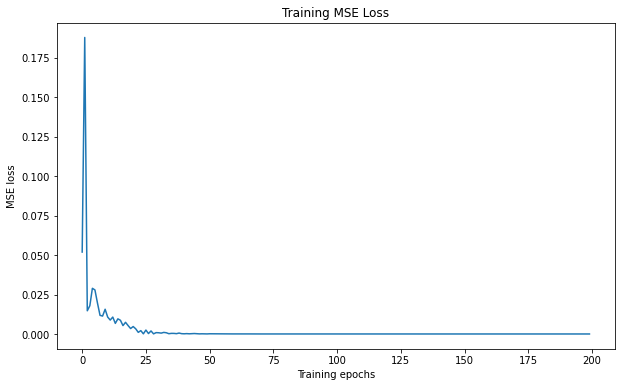

In [22]:
plot_loss(loss_history)

Train Score: 0.60 RMSE
Test Score: 10.59 RMSE


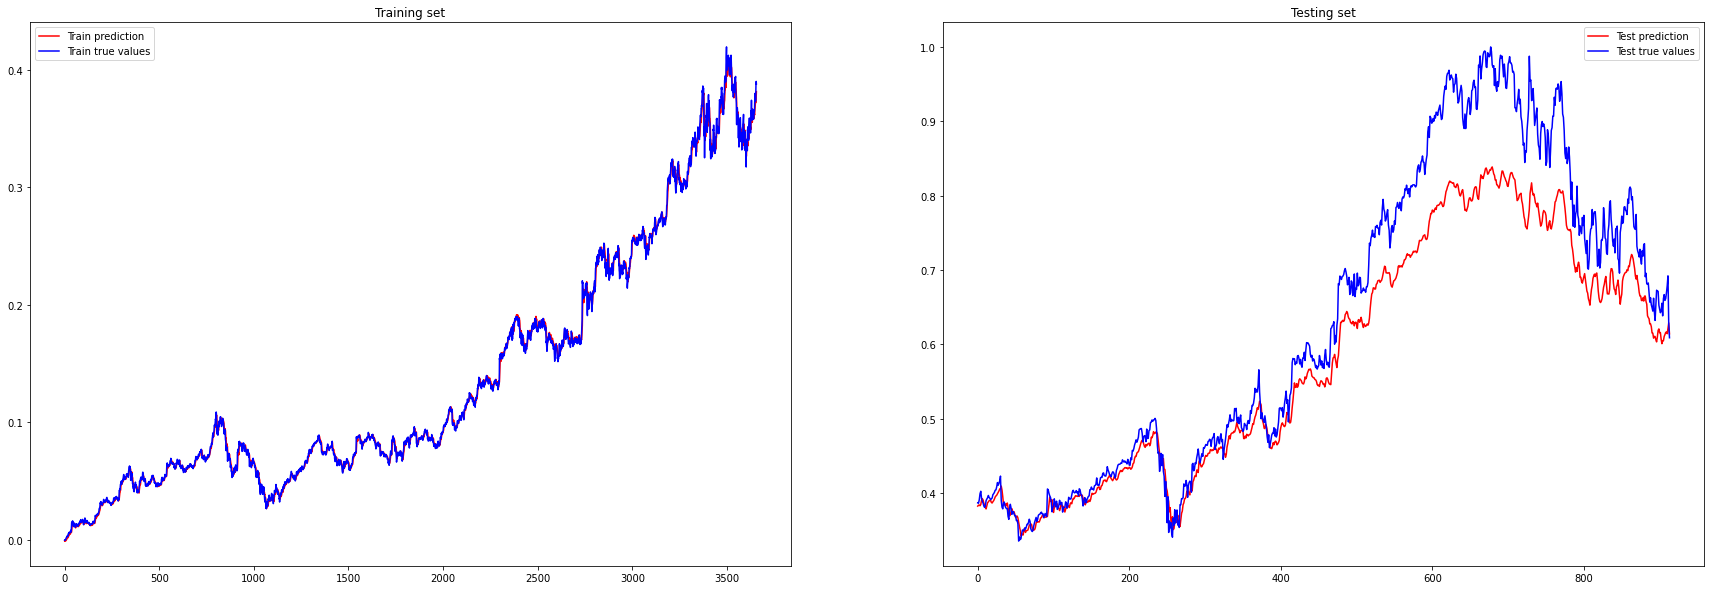

In [23]:
plot_prediction(trained_rnn)

Limitations of RNNS:

    1. Highly sensitive to recent inputs.
    2. Low sensitivity to distant inputs.
    3. Risk of vanishing and exploding gradients.
    4. RNNs are great when important characteristics are a few time-steps back.


# LSTM model

In [24]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        # RNN Layer 
        self.lstm = nn.LSTM(input_size, num_hidden, num_layers, batch_first = True)
        
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        y, hidden = self.lstm(x)
        o = self.out(y)
        return o, hidden

In [25]:
lstm_model = LSTMnet(1, 128, 1)

In [26]:
trained_lstm, lstm_loss_history = train_model(lstm_model)

Epoch: 10 MSE: 0.0069528548046946526
Epoch: 20 MSE: 0.0010380411986261606
Epoch: 30 MSE: 0.00013045003288425505
Epoch: 40 MSE: 0.00013216465595178306
Epoch: 50 MSE: 5.518145553651266e-05
Epoch: 60 MSE: 1.8211572751170024e-05
Epoch: 70 MSE: 2.0688565200543962e-05
Epoch: 80 MSE: 1.506088301539421e-05
Epoch: 90 MSE: 1.5352052287198603e-05
Epoch: 100 MSE: 1.4574327906302642e-05
Epoch: 110 MSE: 1.4556338101101574e-05
Epoch: 120 MSE: 1.4449258742388338e-05
Epoch: 130 MSE: 1.4394957361218985e-05
Epoch: 140 MSE: 1.4364558410306927e-05
Epoch: 150 MSE: 1.4329565601656213e-05
Epoch: 160 MSE: 1.4295881555881351e-05
Epoch: 170 MSE: 1.4262063814385328e-05
Epoch: 180 MSE: 1.4227752217266243e-05
Epoch: 190 MSE: 1.4192634807841387e-05


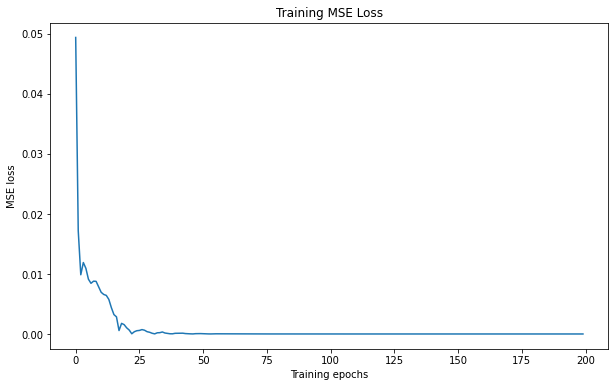

In [27]:
plot_loss(lstm_loss_history)

Train Score: 0.55 RMSE
Test Score: 4.04 RMSE


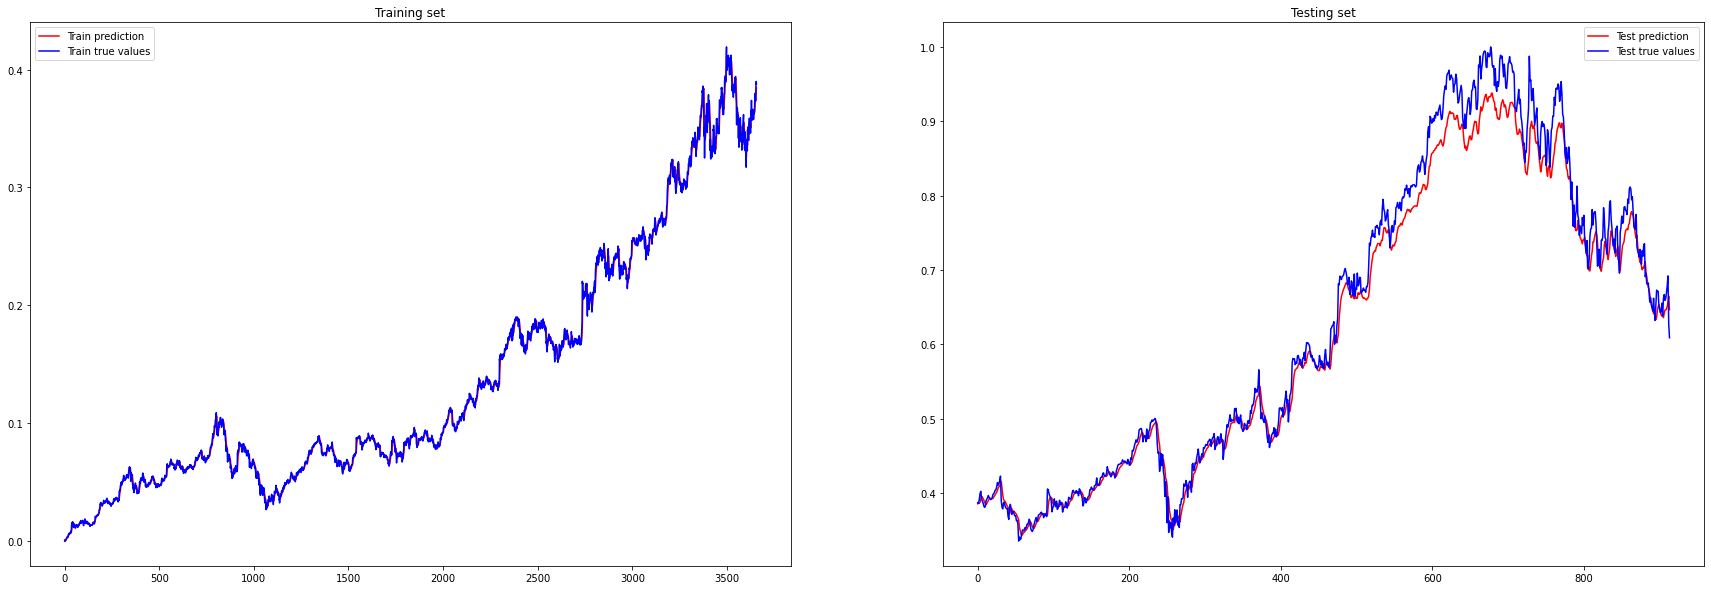

In [28]:
plot_prediction(trained_lstm)

# GRU Model

In [29]:
class GRUnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        # RNN Layer 
        self.gru = nn.GRU(input_size, num_hidden, num_layers, batch_first = True)
        
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        y, hidden = self.gru(x)
        o = self.out(y)
        return o, hidden

In [30]:
grumodel = GRUnet(1, 128, 1)

In [31]:
trained_gru, gru_loss_history = train_model(grumodel)

Epoch: 10 MSE: 0.008138728328049183
Epoch: 20 MSE: 0.0015393440844491124
Epoch: 30 MSE: 0.0005023485864512622
Epoch: 40 MSE: 0.00018477626144886017
Epoch: 50 MSE: 3.874832691508345e-05
Epoch: 60 MSE: 3.189255585311912e-05
Epoch: 70 MSE: 1.5424386219820008e-05
Epoch: 80 MSE: 1.683201662672218e-05
Epoch: 90 MSE: 1.6180691090994515e-05
Epoch: 100 MSE: 1.5043559869809542e-05
Epoch: 110 MSE: 1.4594821550417691e-05
Epoch: 120 MSE: 1.4463517800322734e-05
Epoch: 130 MSE: 1.4344565897772554e-05
Epoch: 140 MSE: 1.4221051969798282e-05
Epoch: 150 MSE: 1.4115013073023874e-05
Epoch: 160 MSE: 1.4011846360517666e-05
Epoch: 170 MSE: 1.3912581380282063e-05
Epoch: 180 MSE: 1.3816979844705202e-05
Epoch: 190 MSE: 1.3723733900405932e-05


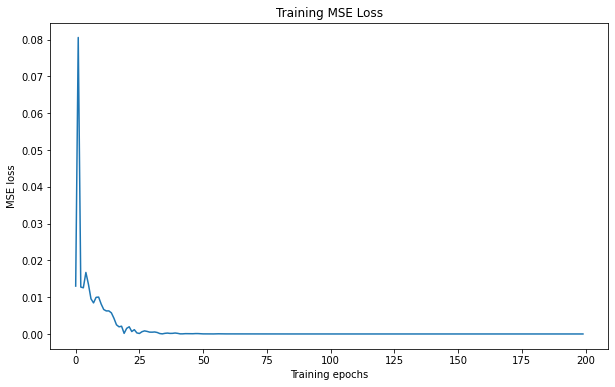

In [32]:
plot_loss(gru_loss_history)

Train Score: 0.54 RMSE
Test Score: 3.01 RMSE


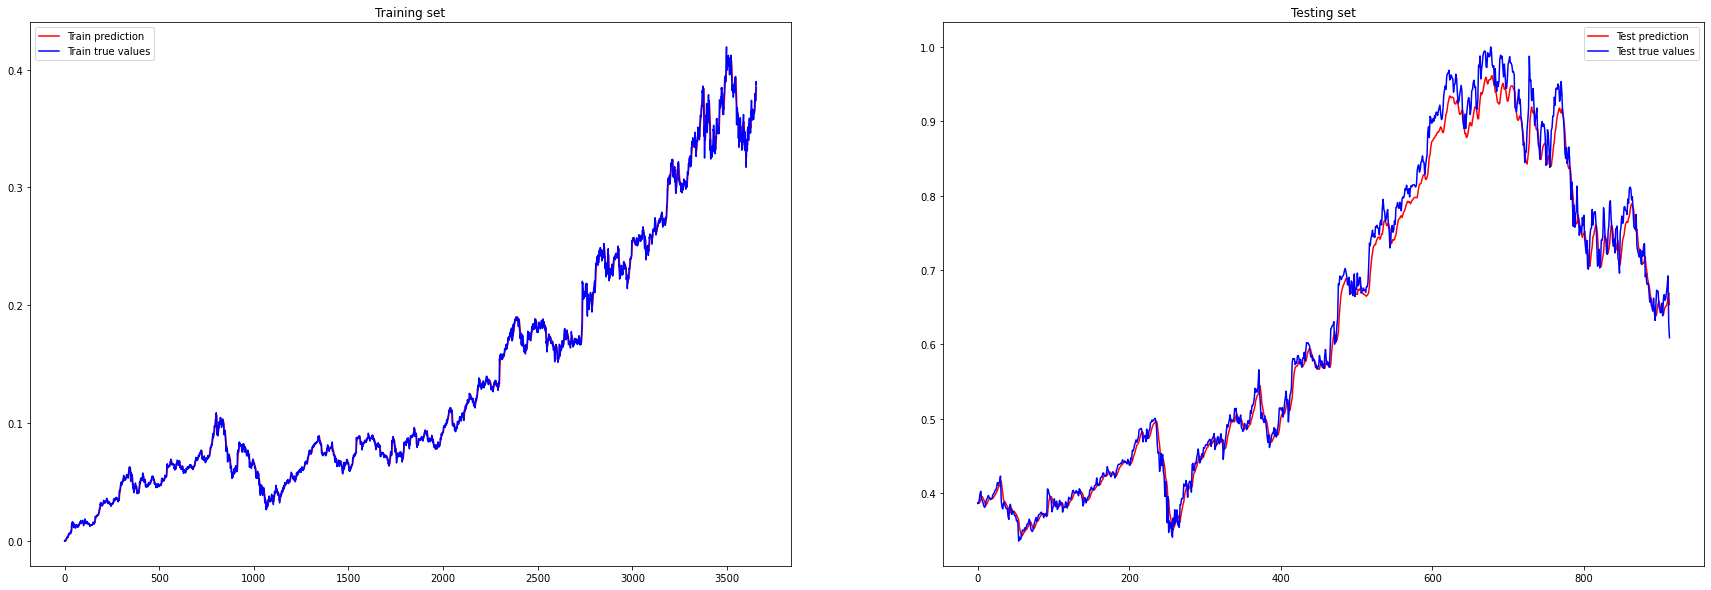

In [33]:
plot_prediction(trained_gru)

# Optimise model structure

In [34]:
input_size = 1 
hidden_size = [32, 64, 128]
num_layers = [1, 2, 3]

## RNN model

Current RNN model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.48 RMSE
Test Score: 6.27 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.64 RMSE
Test Score: 19.52 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.62 RMSE
Test Score: 20.77 RMSE

Current RNN model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.51 RMSE
Test Score: 7.42 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.83 RMSE
Test Score: 26.16 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 1.28 RMSE
Test Score: 31.37 RMSE

Current RNN model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 15.07 RMSE
Test Score: 77.05 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 15.32 RMSE
Test Score: 78.35 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 1.17 RMSE
Test Score: 124.51 RMSE



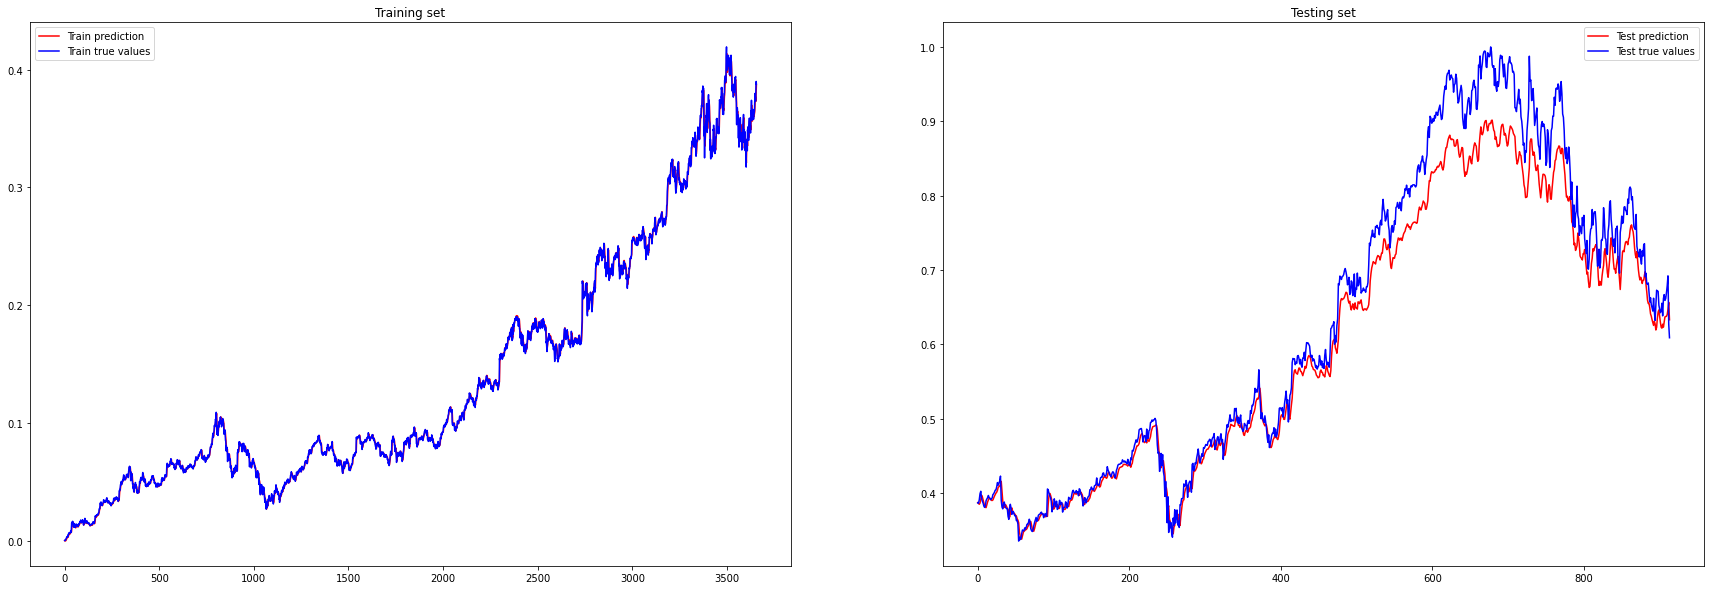

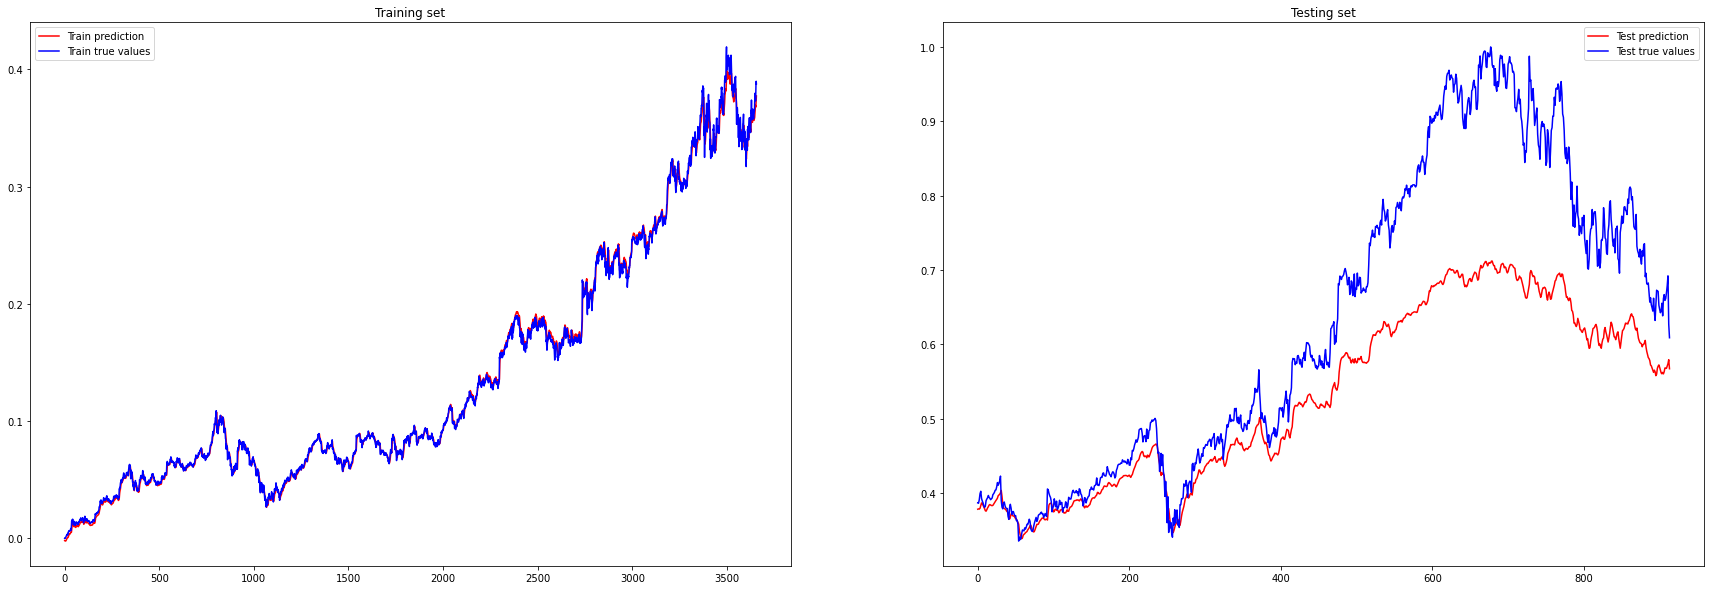

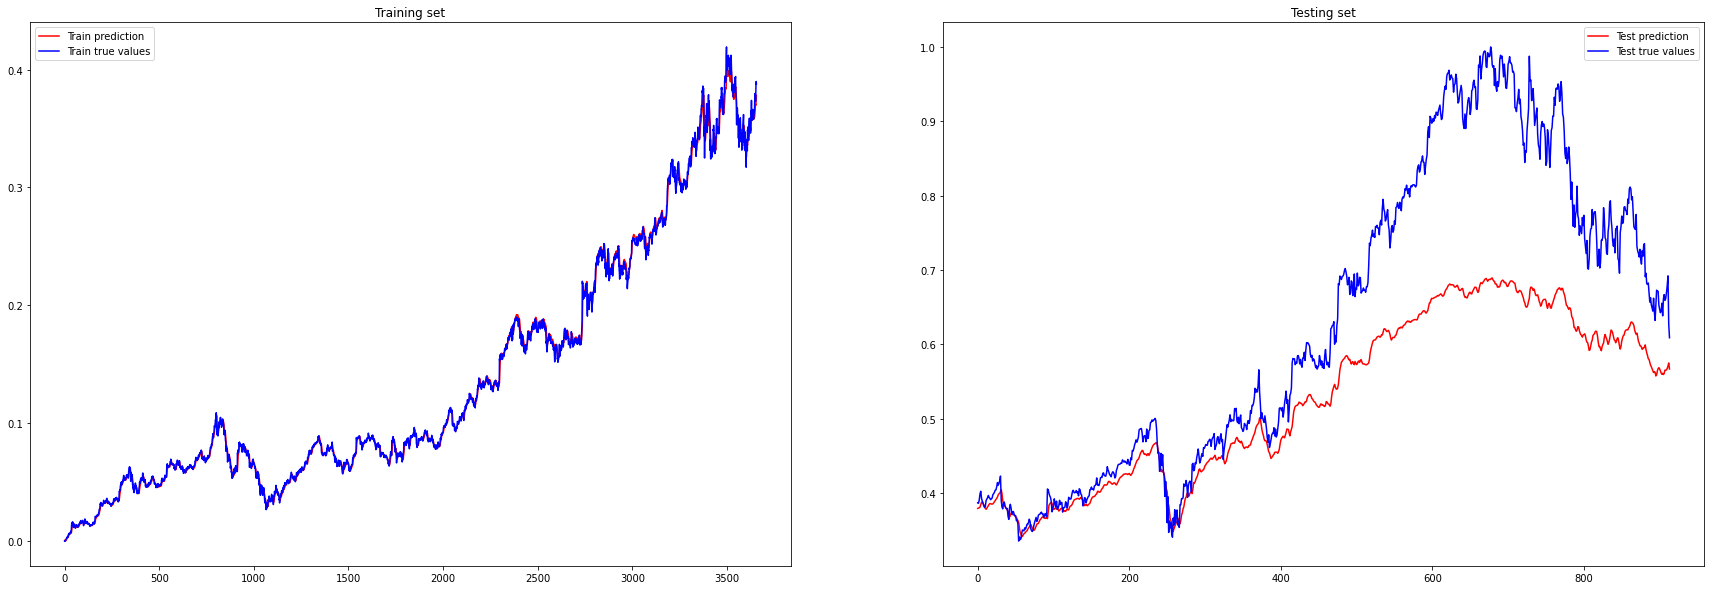

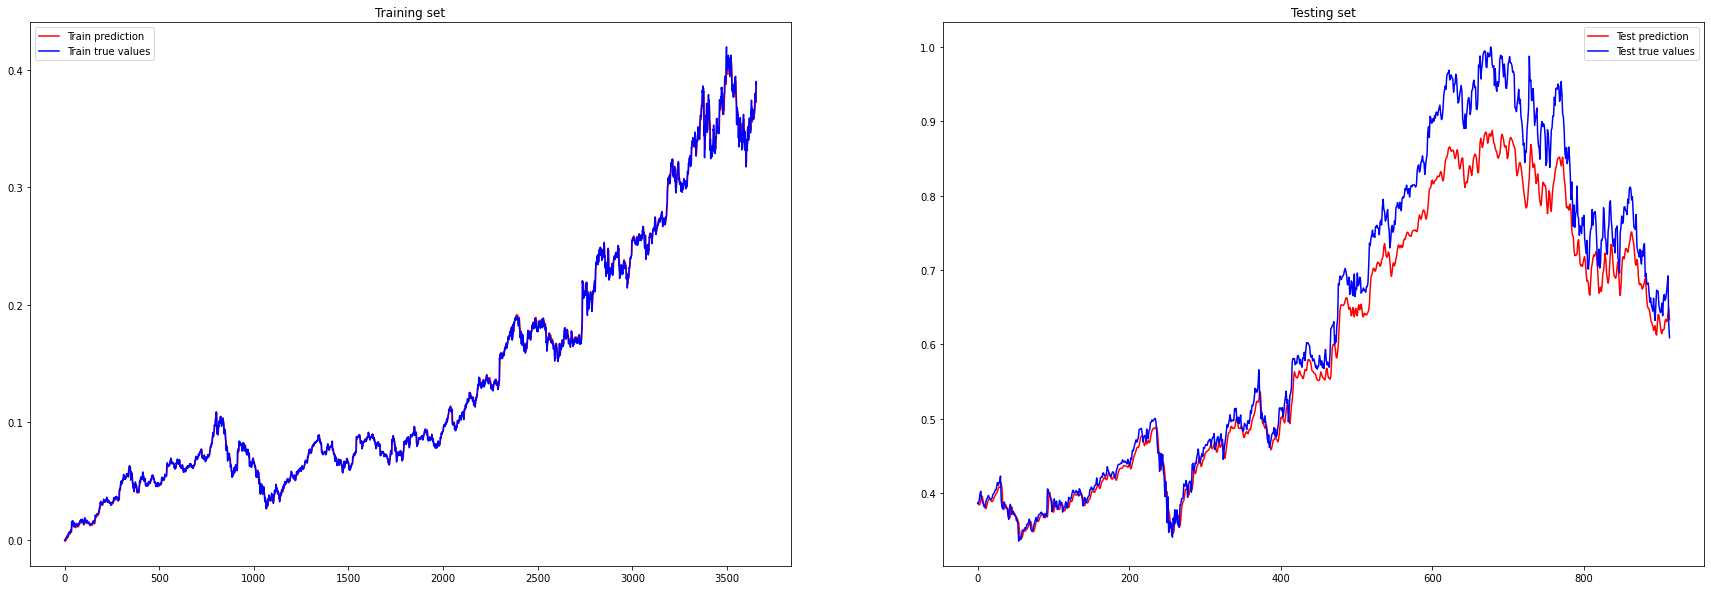

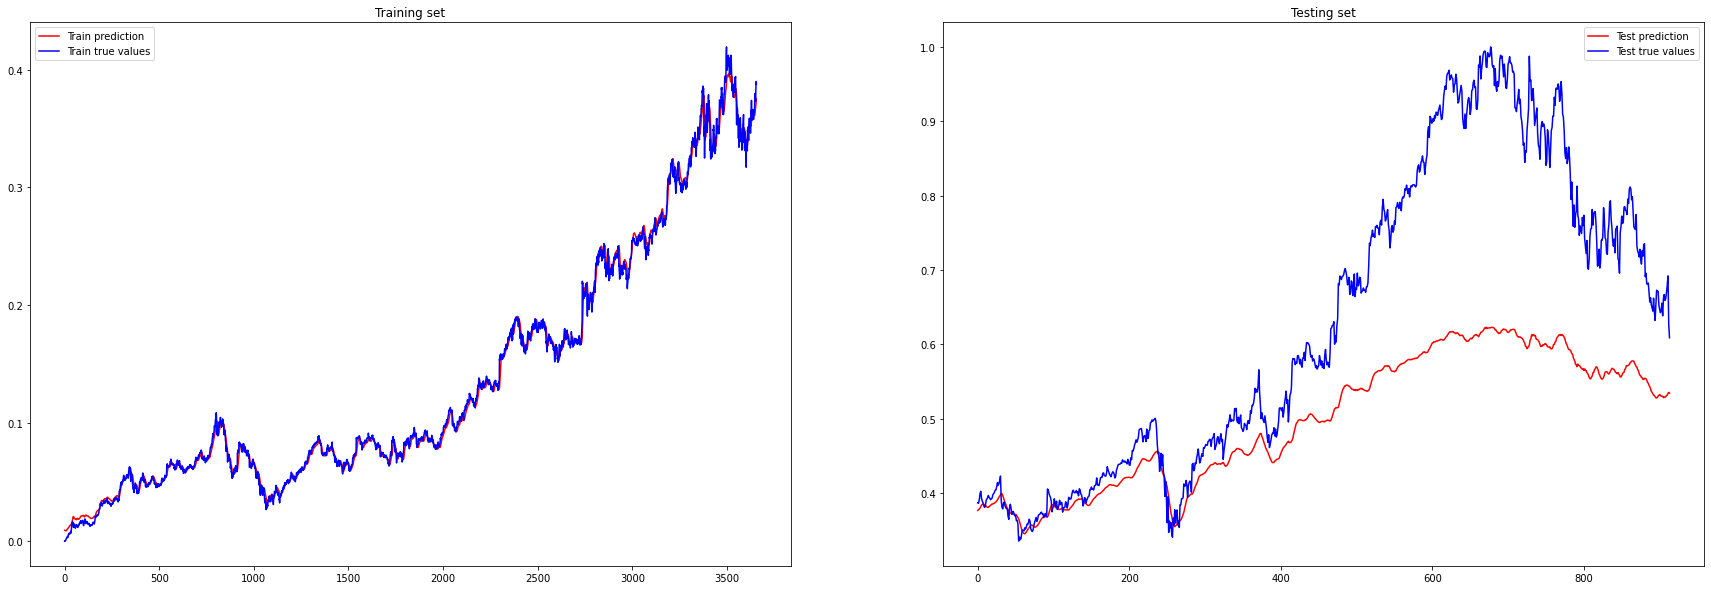

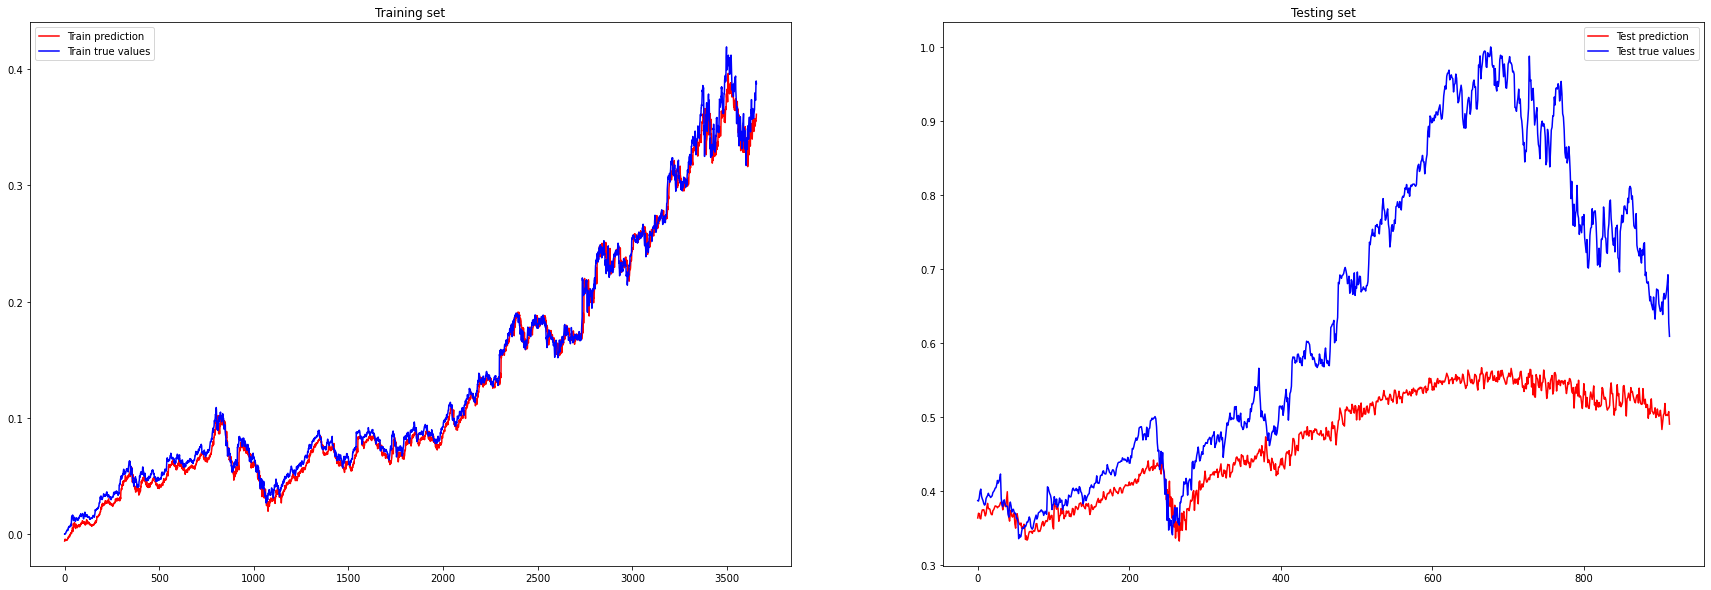

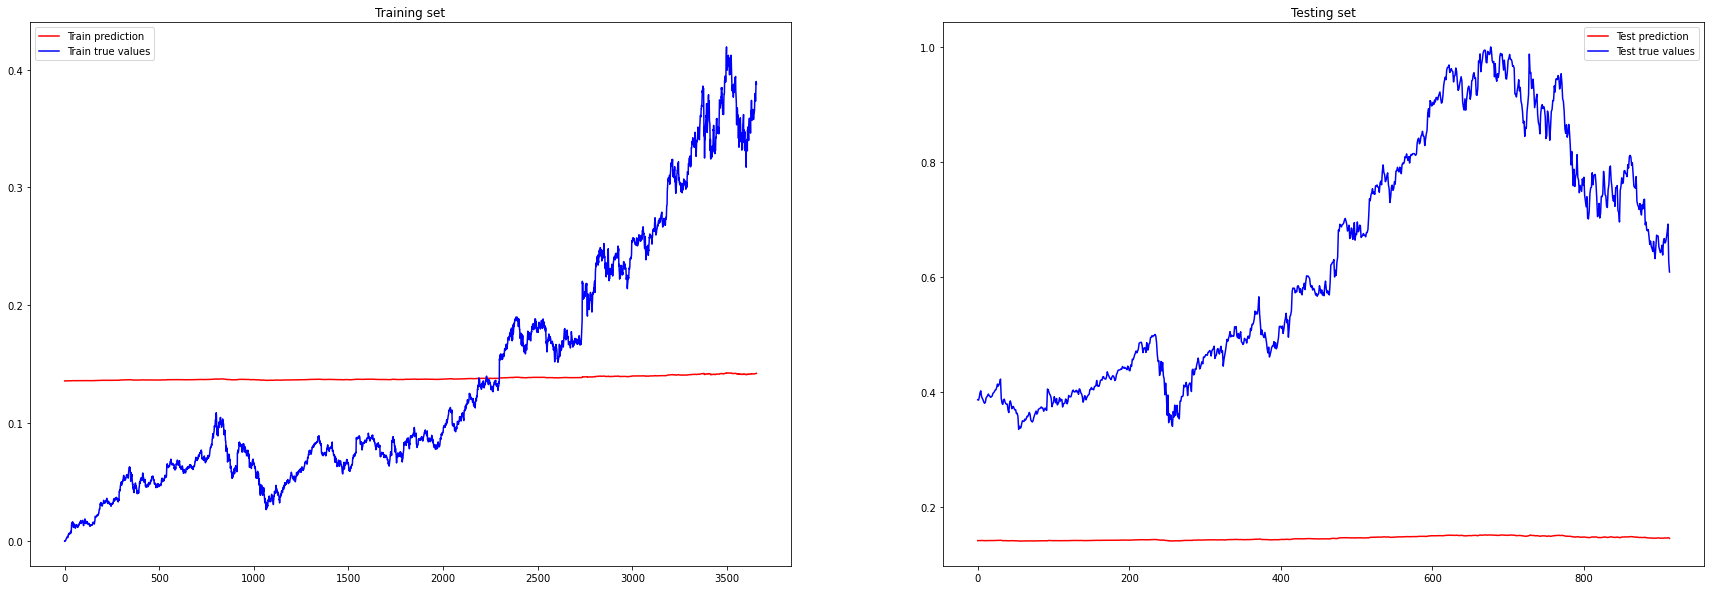

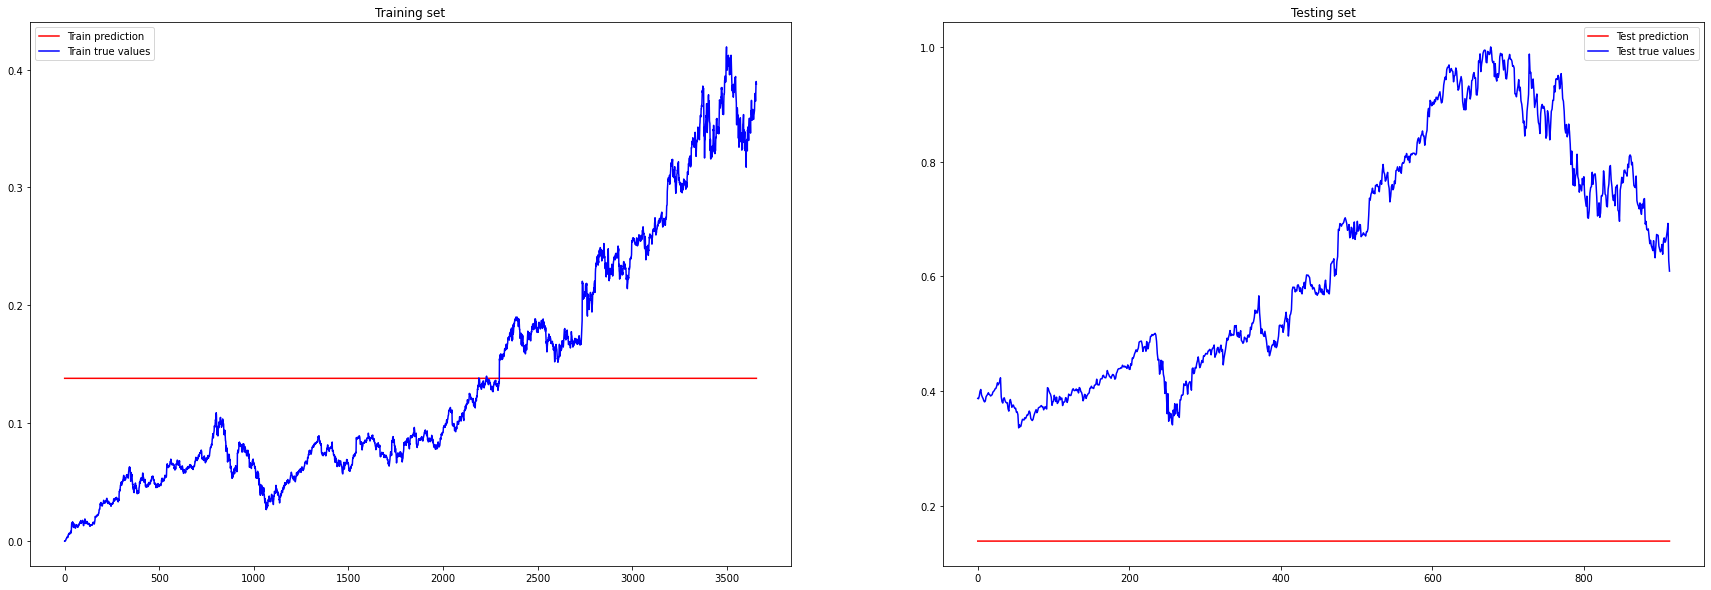

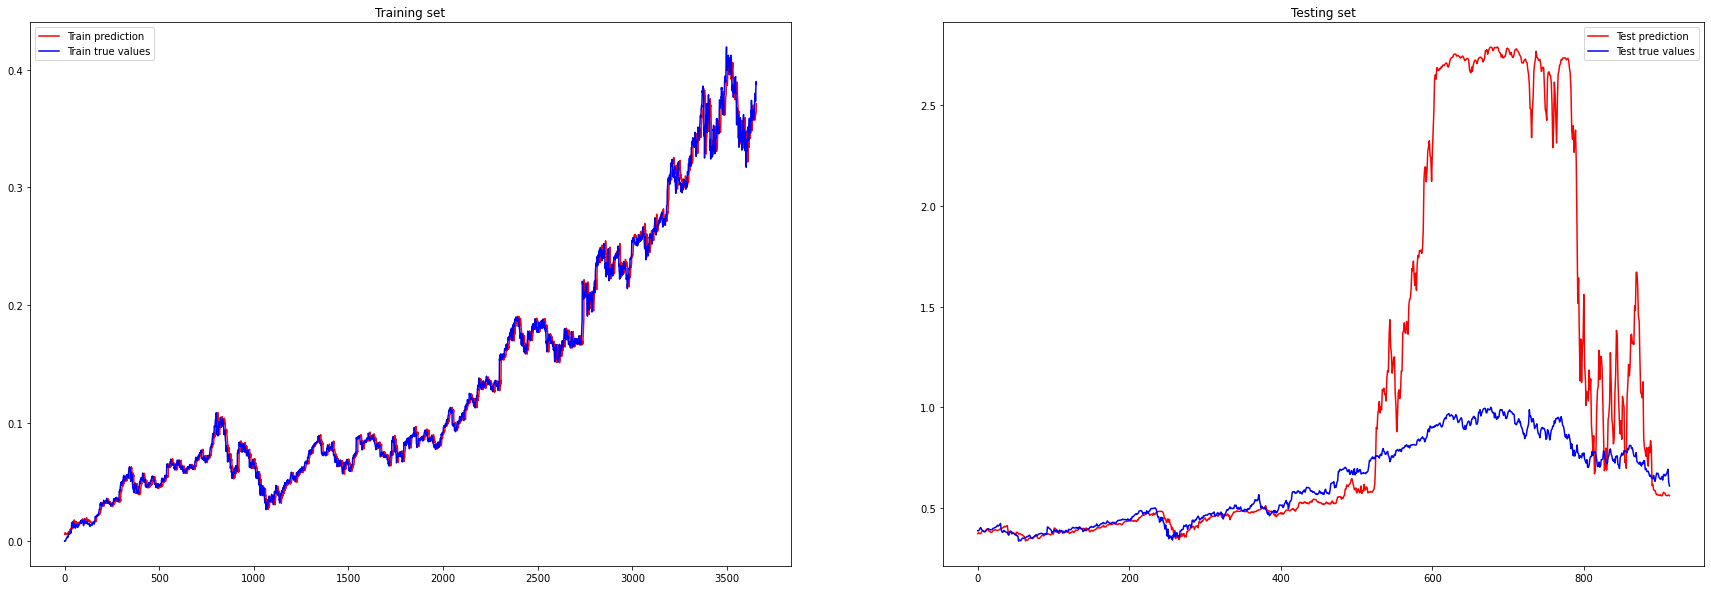

In [35]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current RNN model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_rnn = RNNnet(input_size, hs, nl)   
        trained_rnn_test, test_rnn_loss = train_model(test_rnn, verbose=0)
        plot_prediction(trained_rnn_test)
        print()   

## LSTM model

Current LSTM model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.61 RMSE
Test Score: 8.44 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.80 RMSE
Test Score: 24.40 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.90 RMSE
Test Score: 28.64 RMSE

Current LSTM model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.56 RMSE
Test Score: 5.32 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.71 RMSE
Test Score: 14.35 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 0.82 RMSE
Test Score: 28.90 RMSE

Current LSTM model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 0.57 RMSE
Test Score: 5.25 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 0.82 RMSE
Test Score: 31.32 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 0.87 RMSE
Test Score: 30.94 RMSE



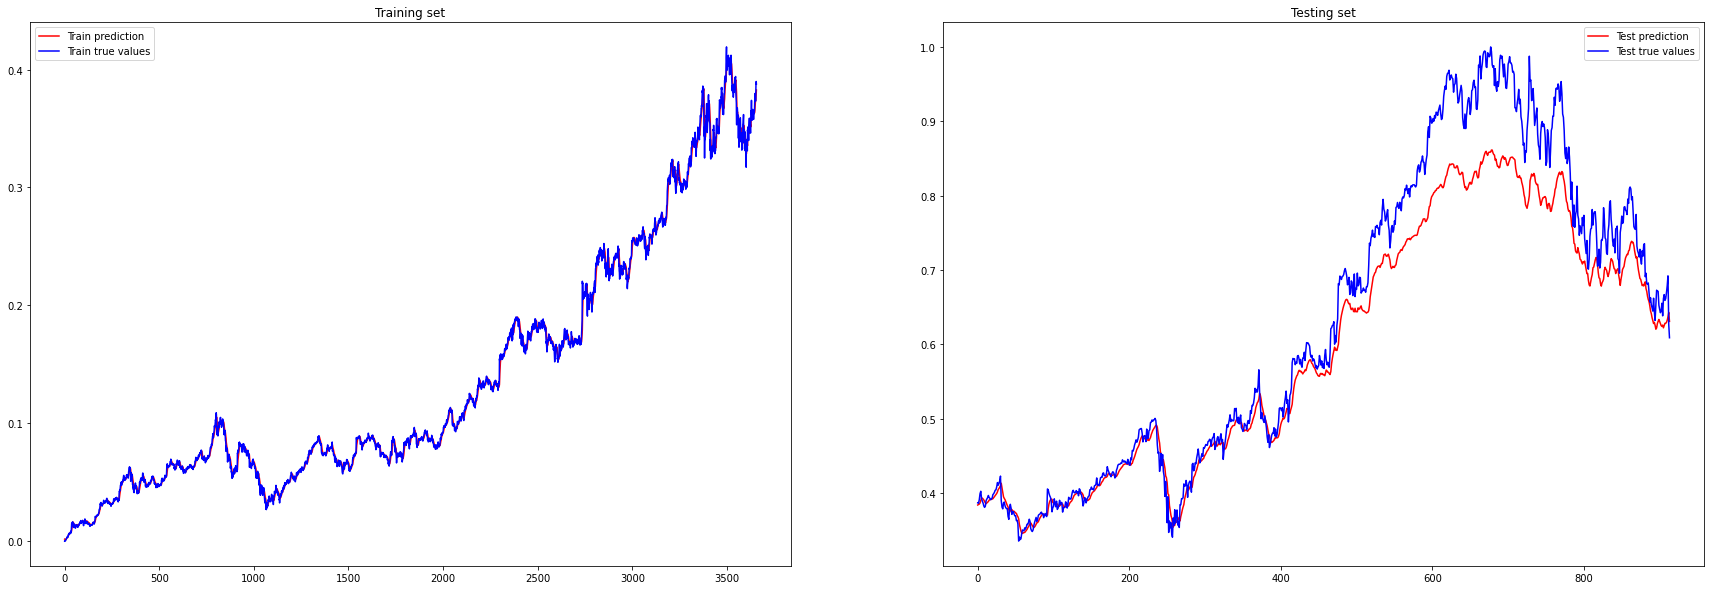

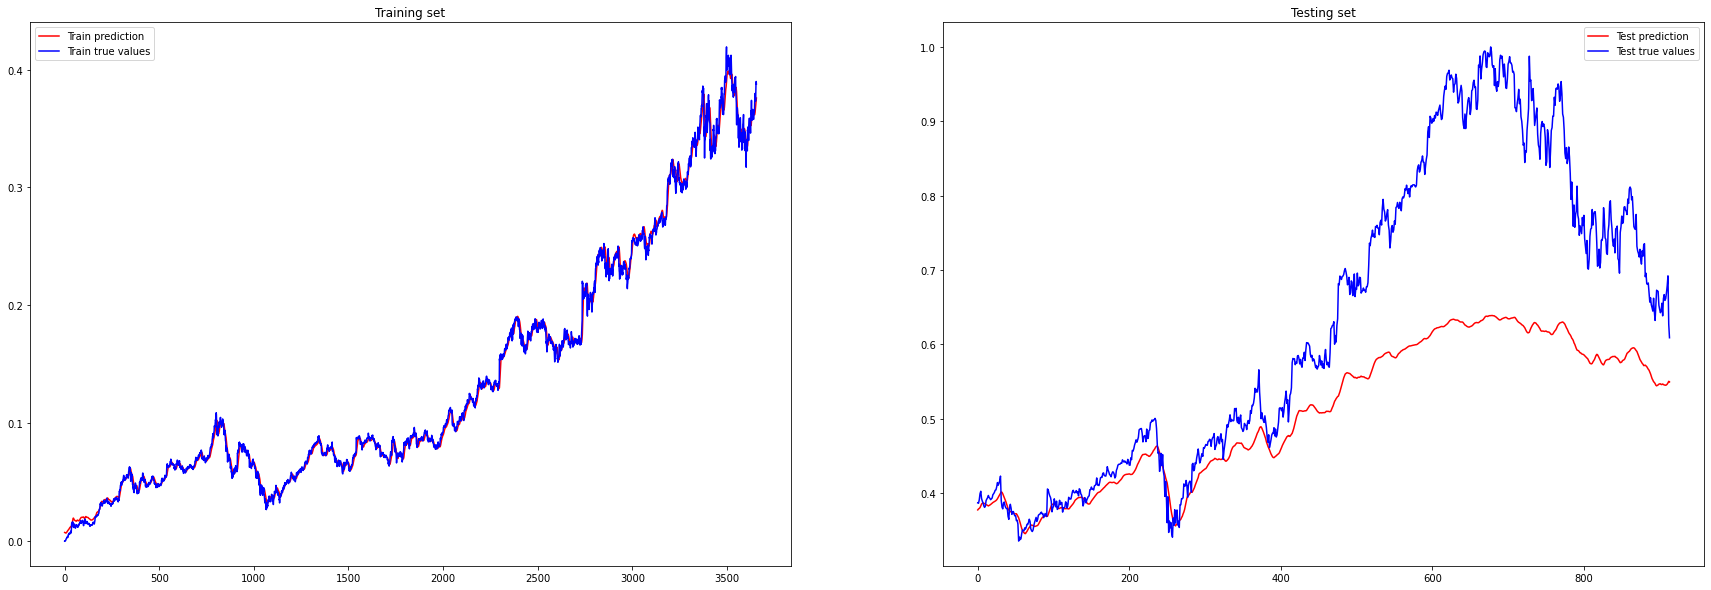

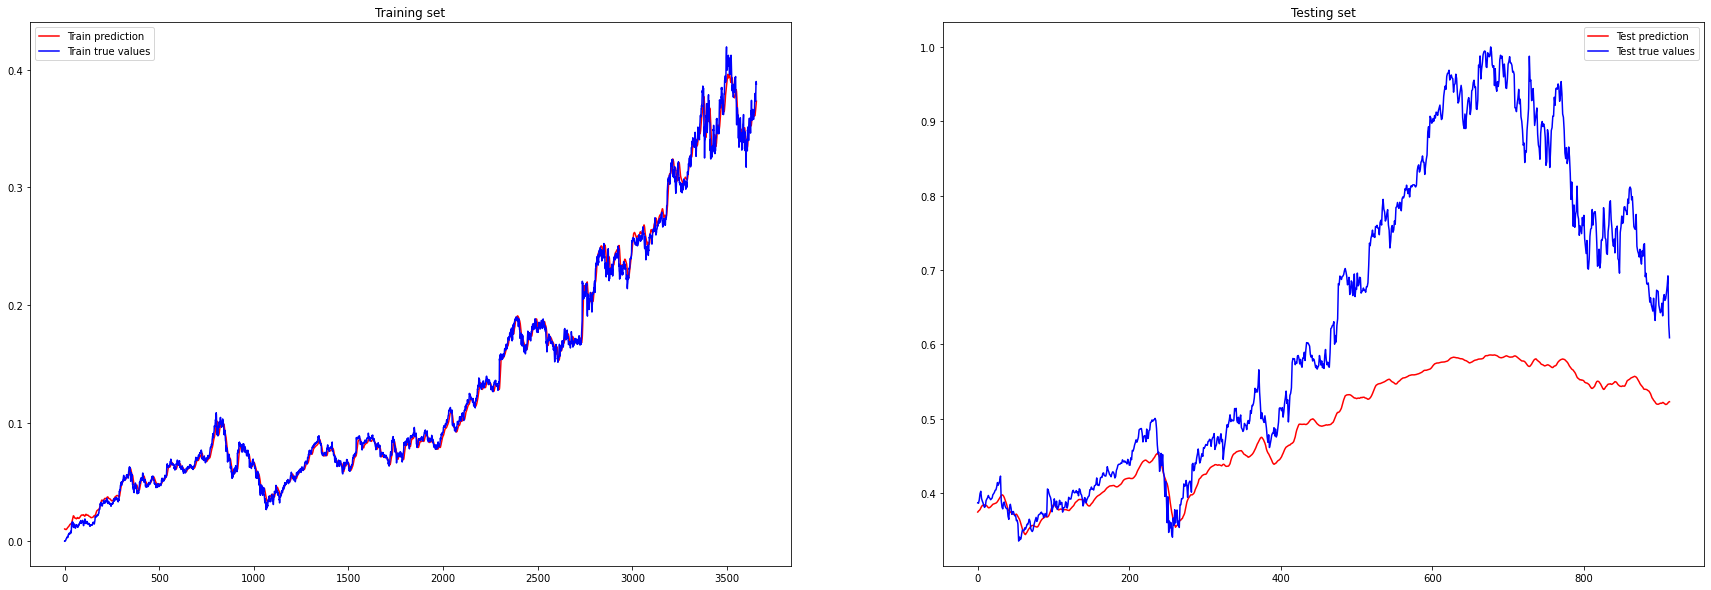

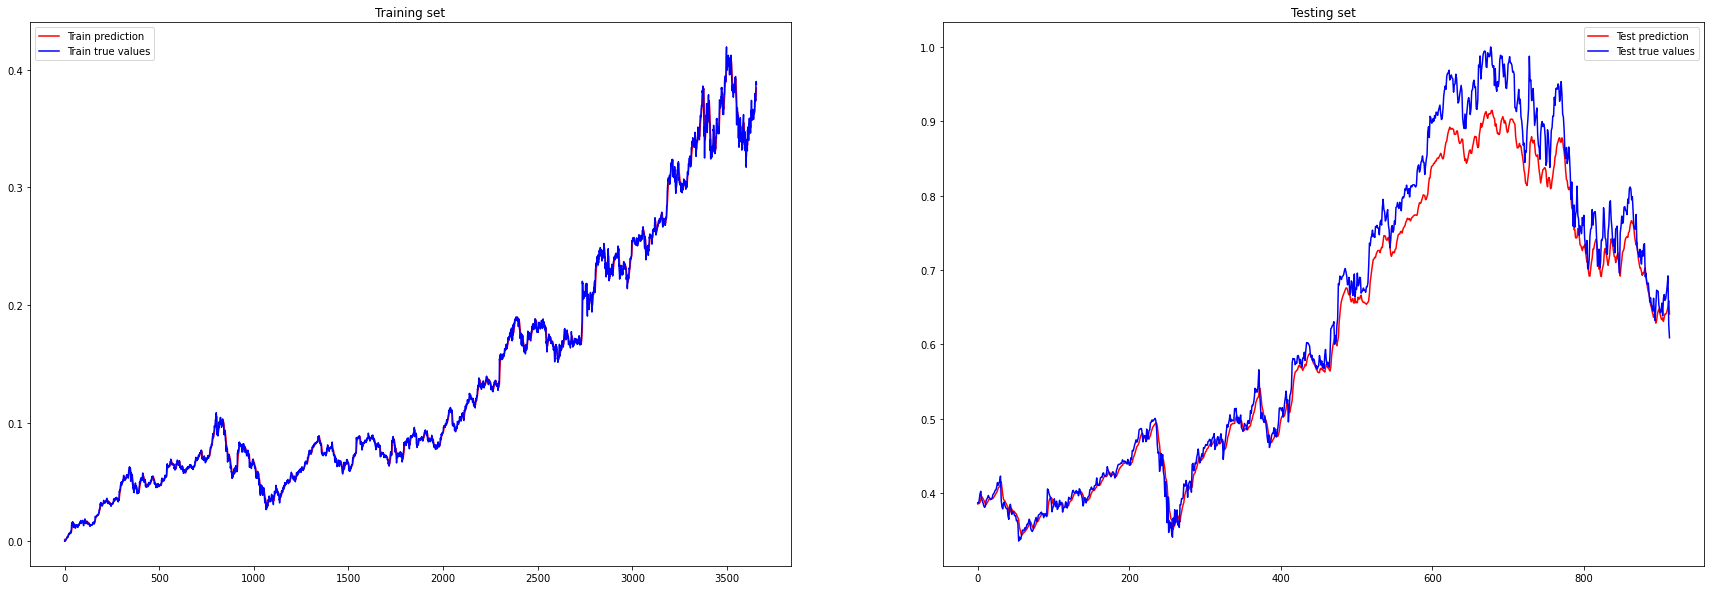

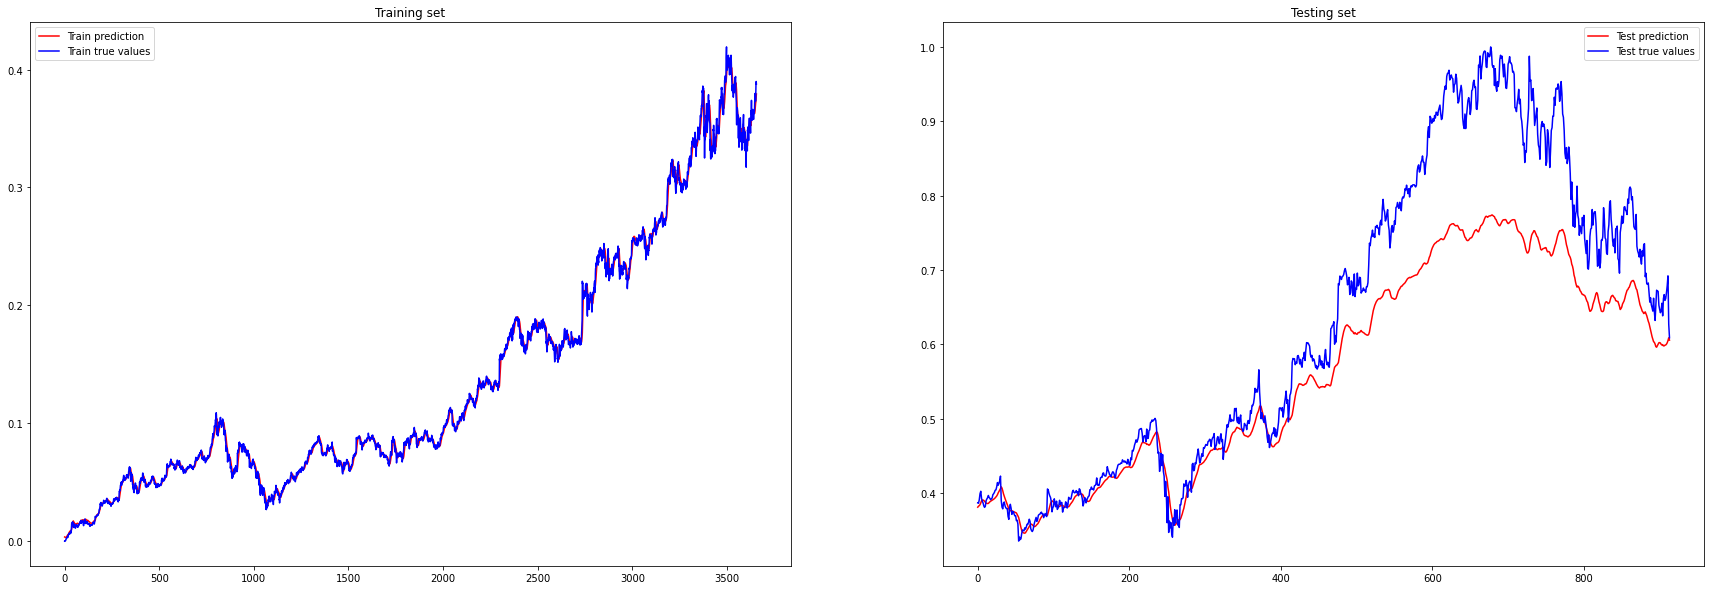

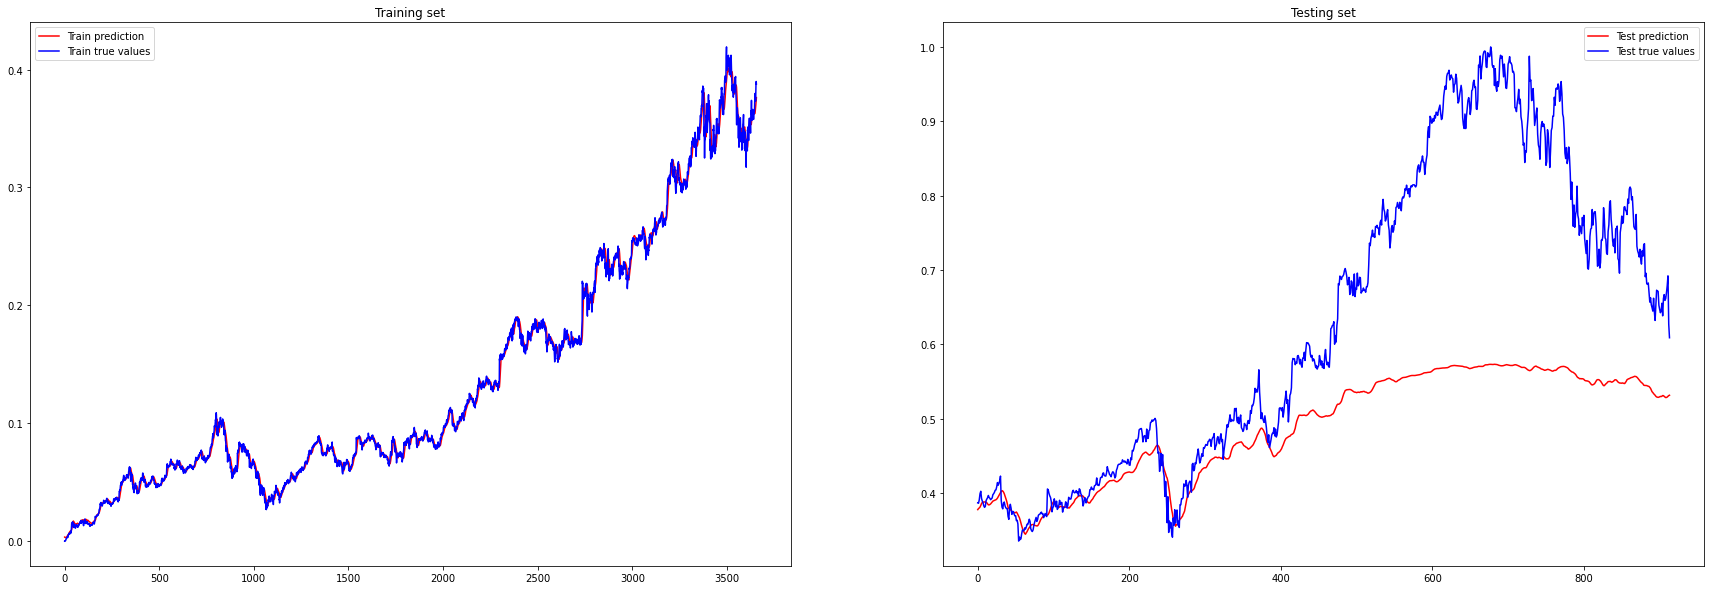

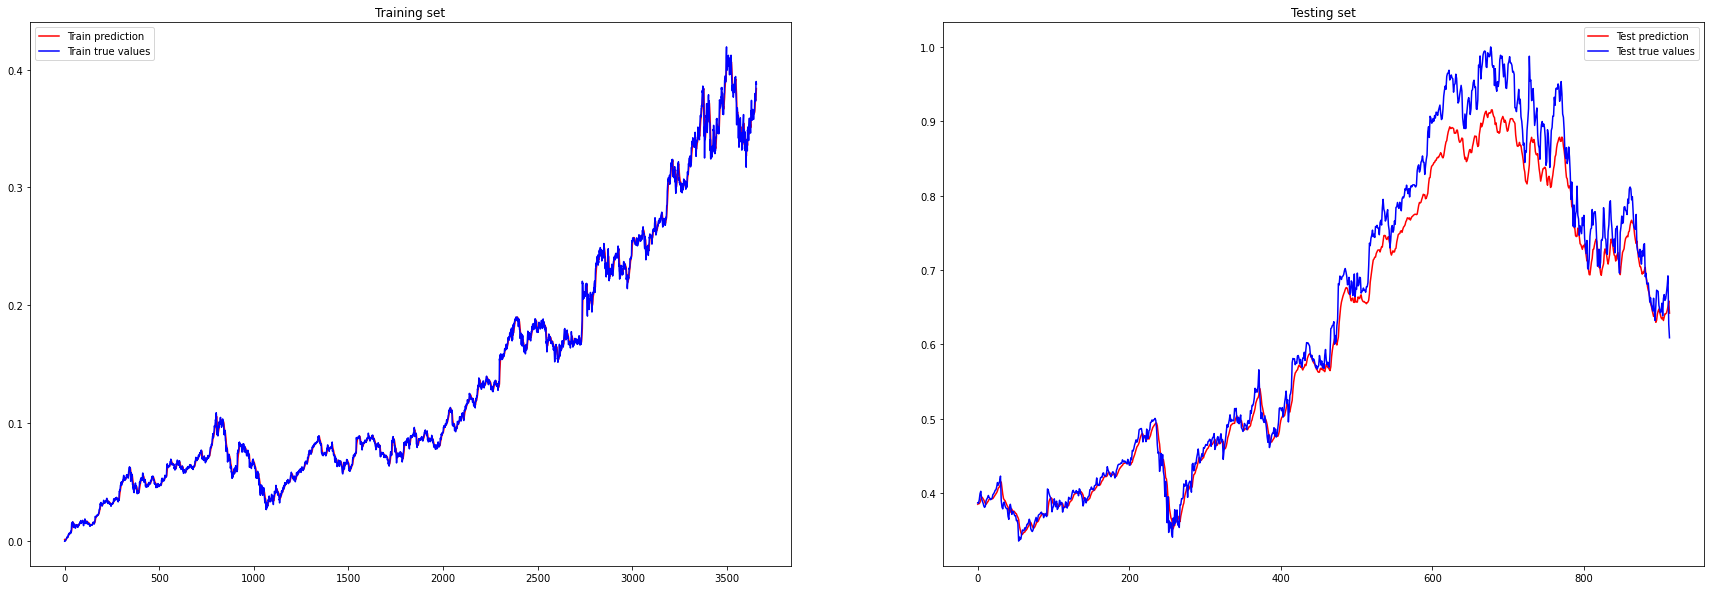

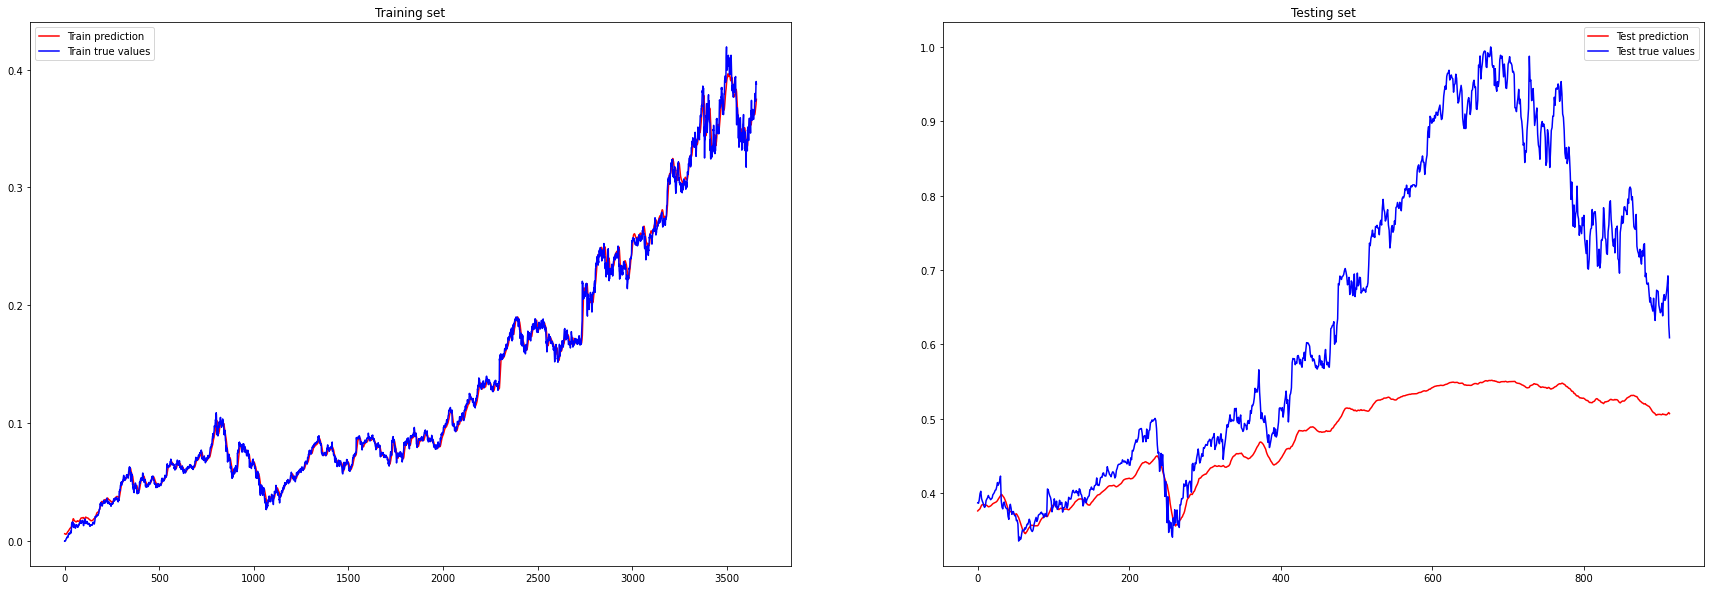

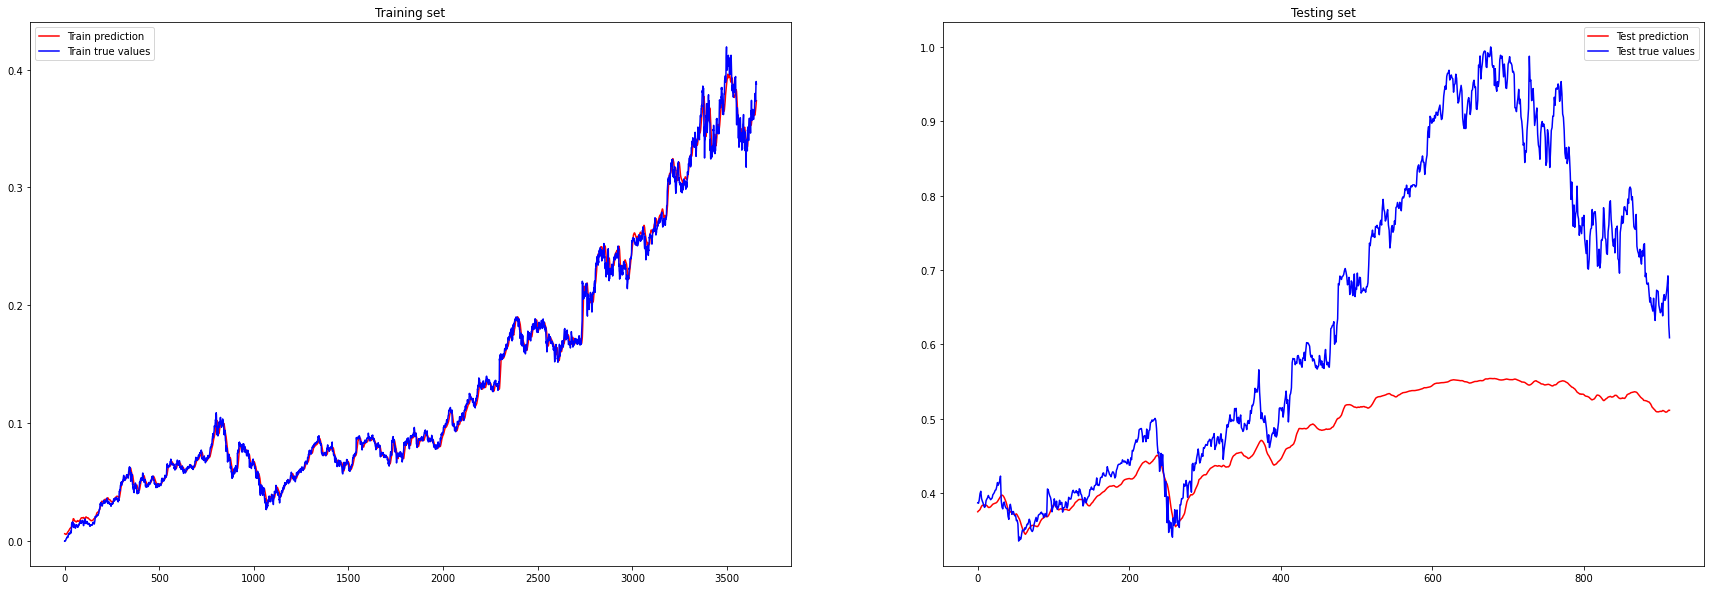

In [36]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current LSTM model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_lstm = LSTMnet(input_size, hs, nl)   
        trained_lstm_test, test_lstm_loss = train_model(test_lstm, verbose=0)
        plot_prediction(trained_lstm_test)
        print()
        

## GRU model

Current gru model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.52 RMSE
Test Score: 4.11 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.64 RMSE
Test Score: 8.26 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.78 RMSE
Test Score: 21.62 RMSE

Current gru model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.54 RMSE
Test Score: 3.21 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.67 RMSE
Test Score: 8.75 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 0.74 RMSE
Test Score: 11.48 RMSE

Current gru model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 0.55 RMSE
Test Score: 3.40 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 0.64 RMSE
Test Score: 6.05 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 0.76 RMSE
Test Score: 12.66 RMSE



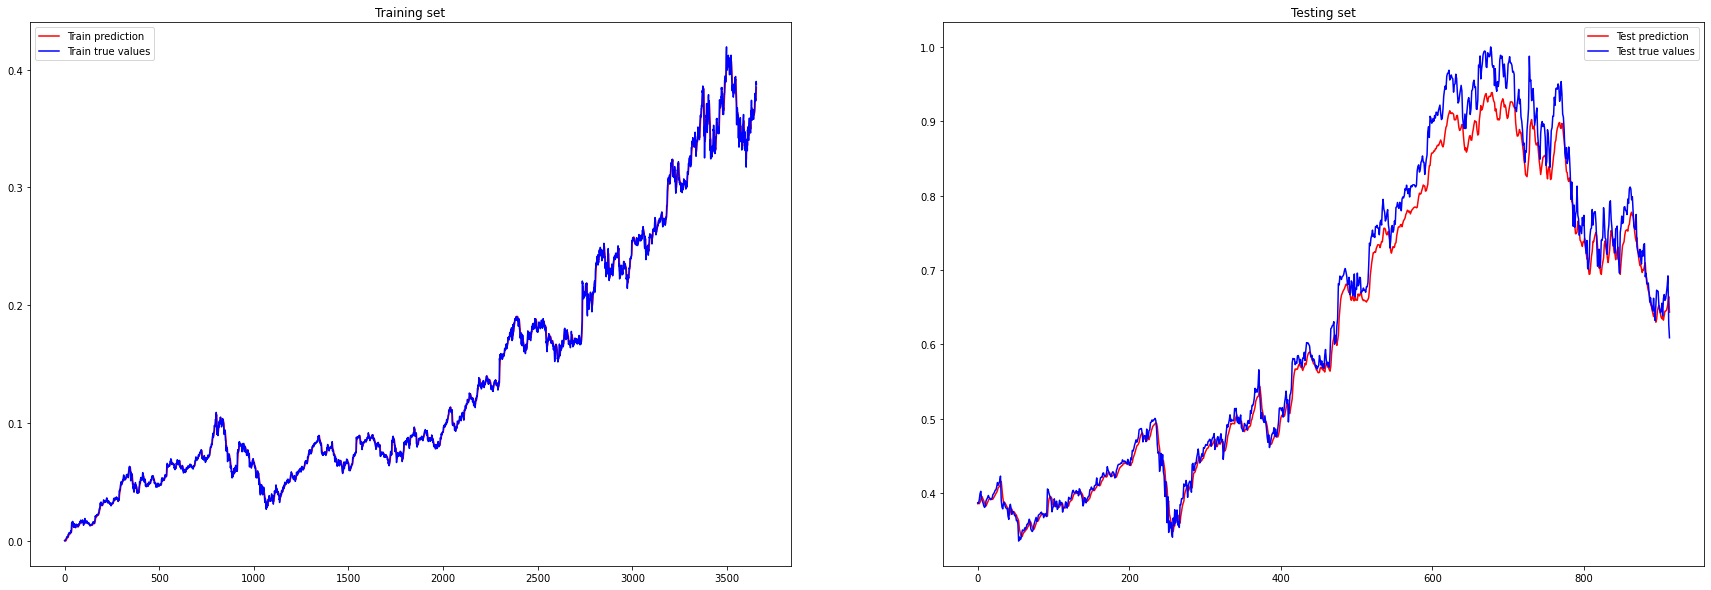

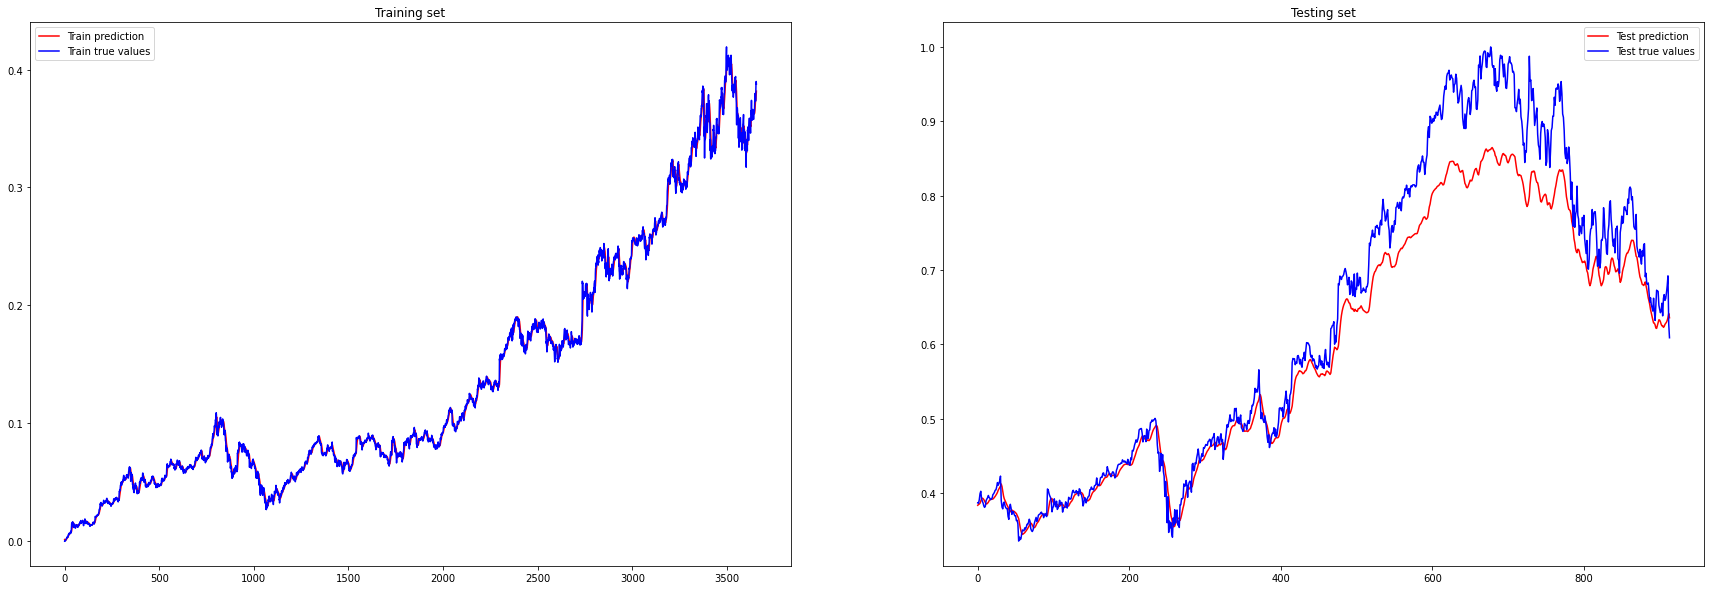

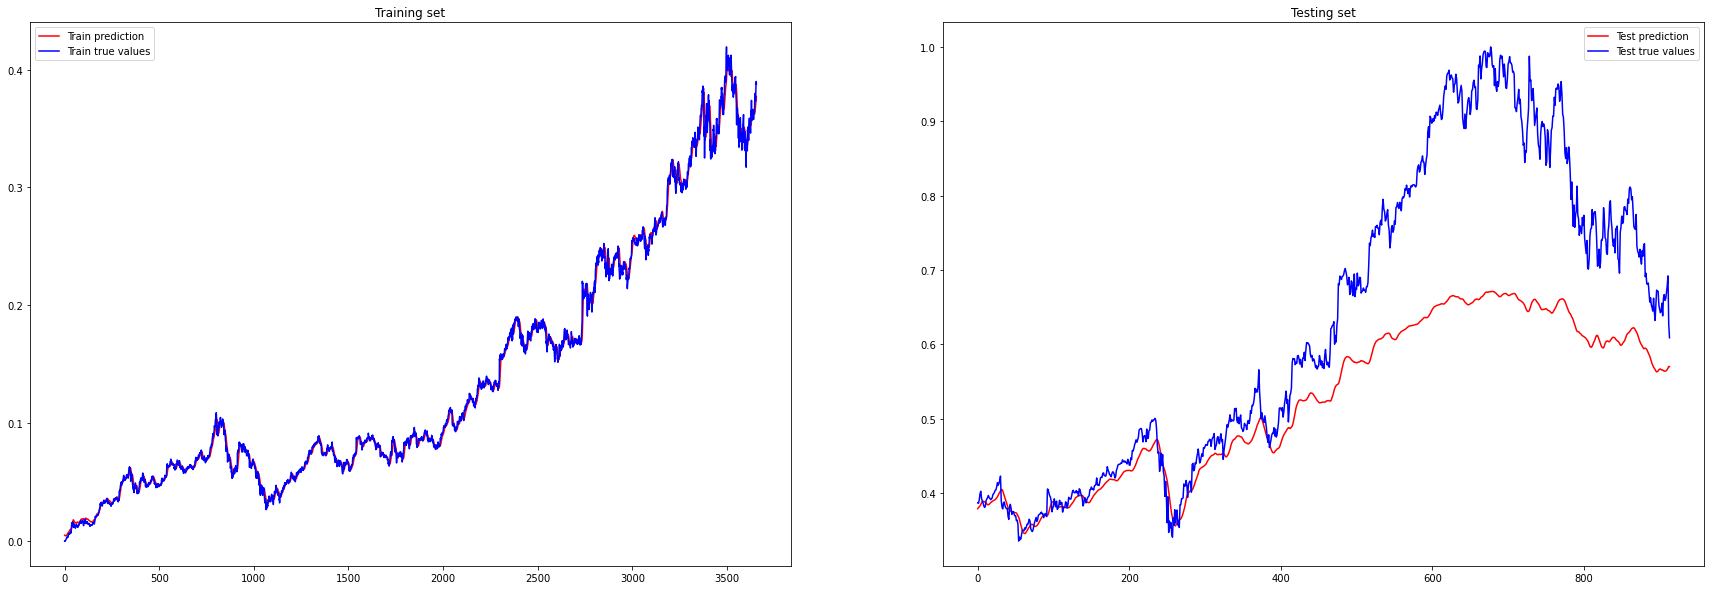

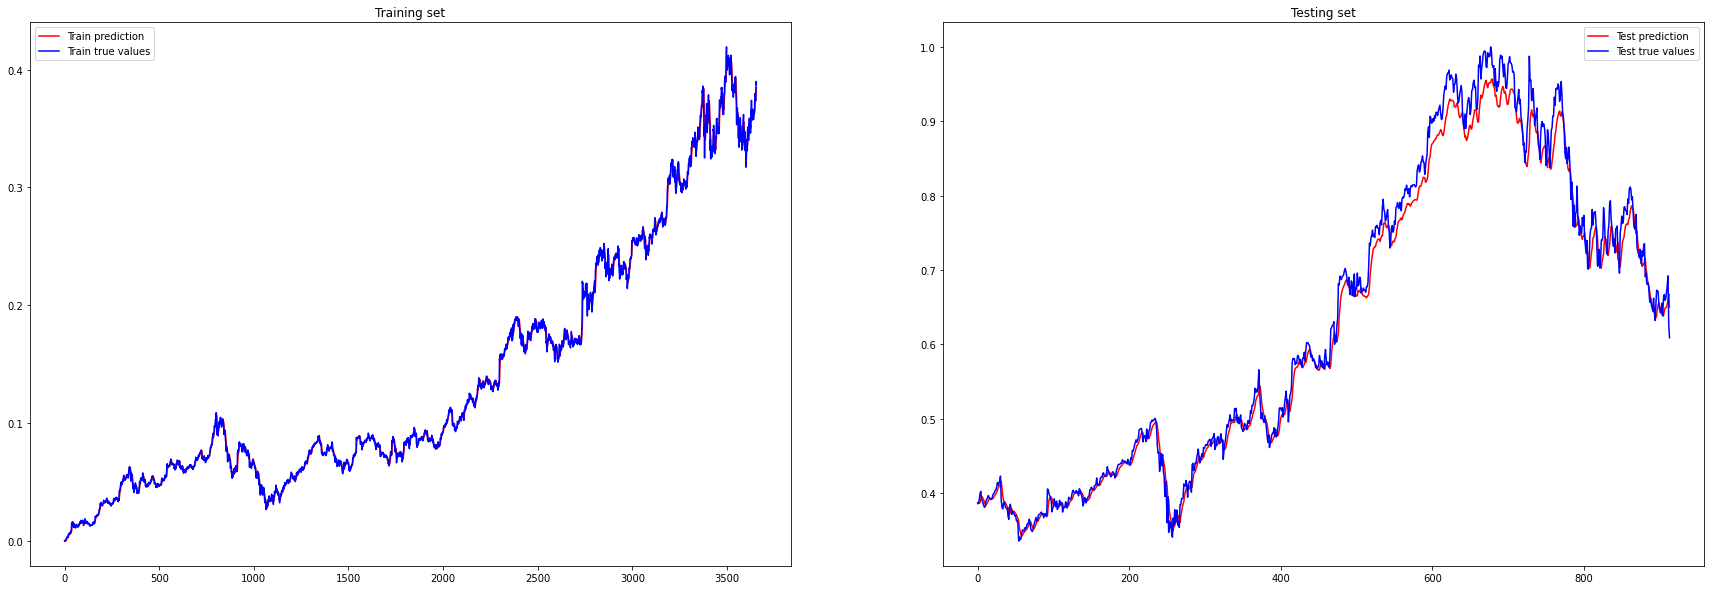

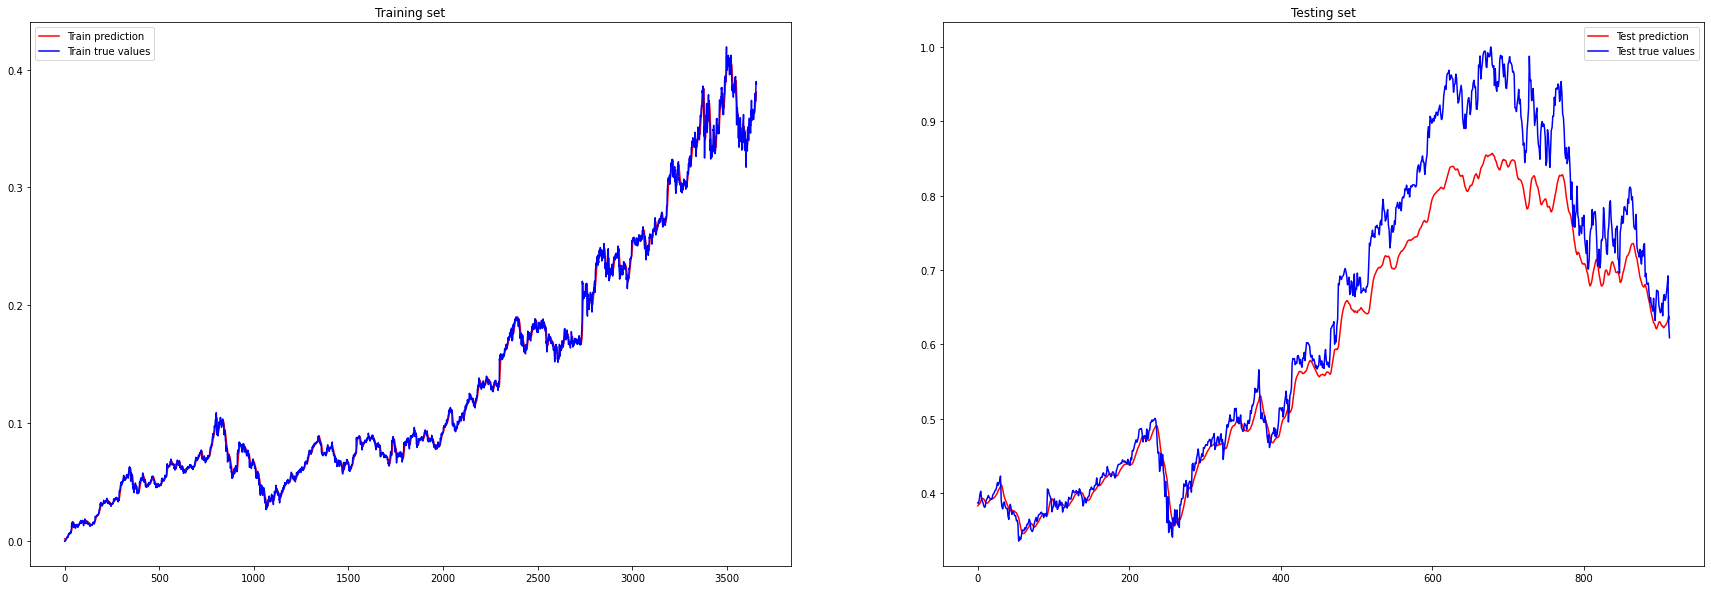

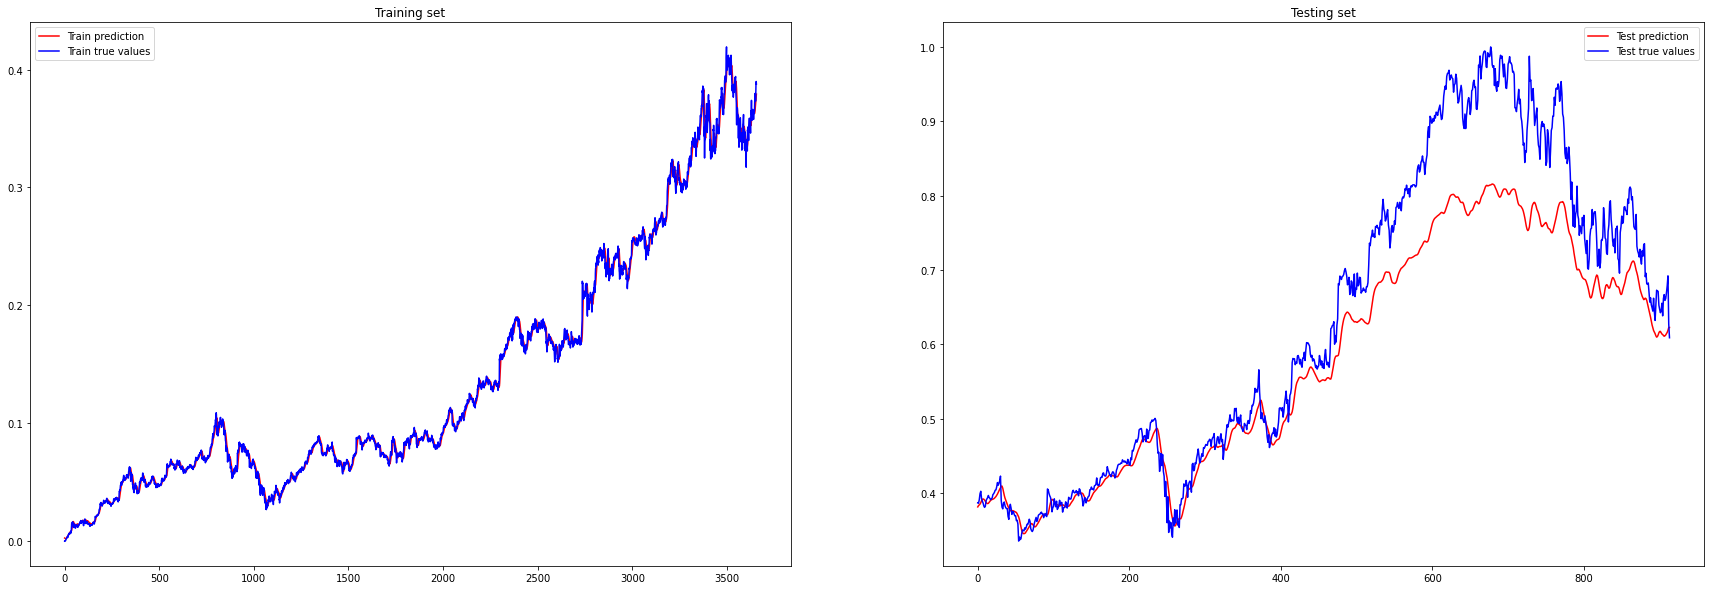

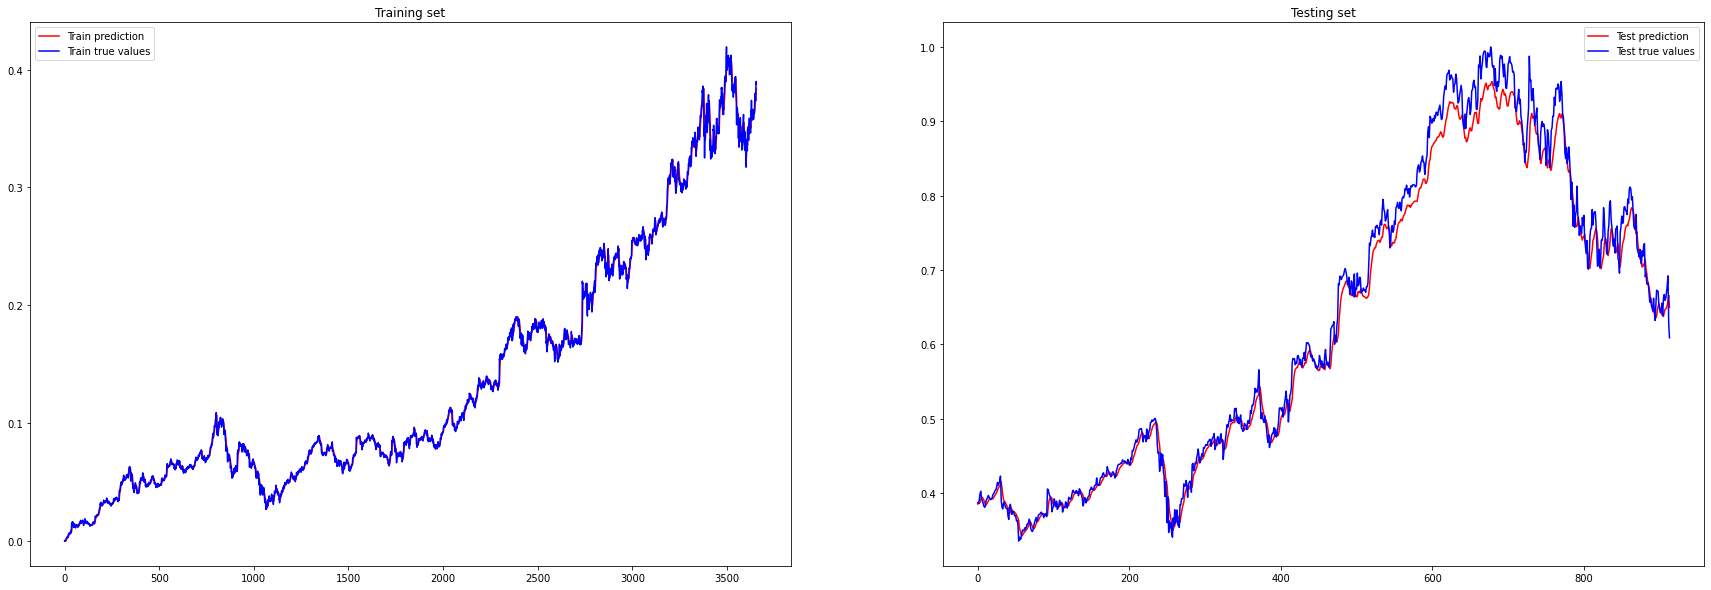

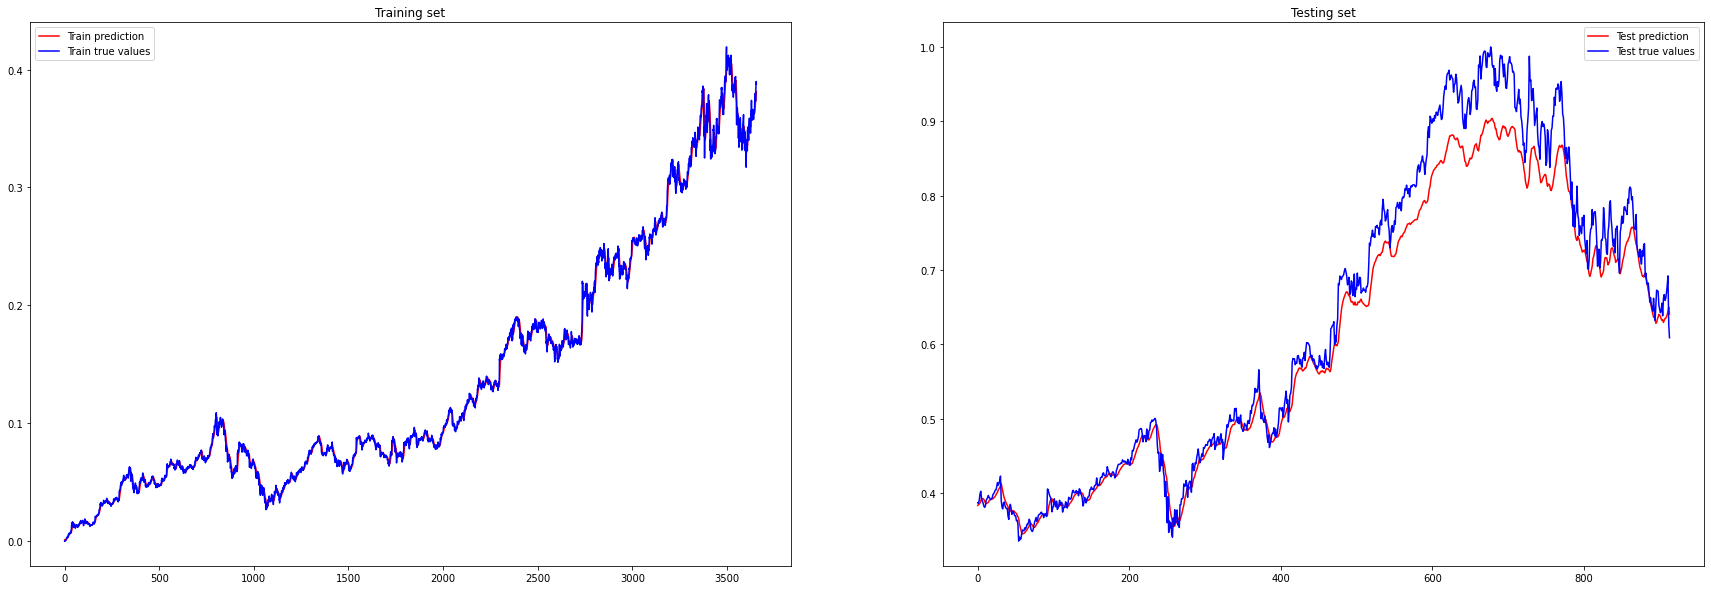

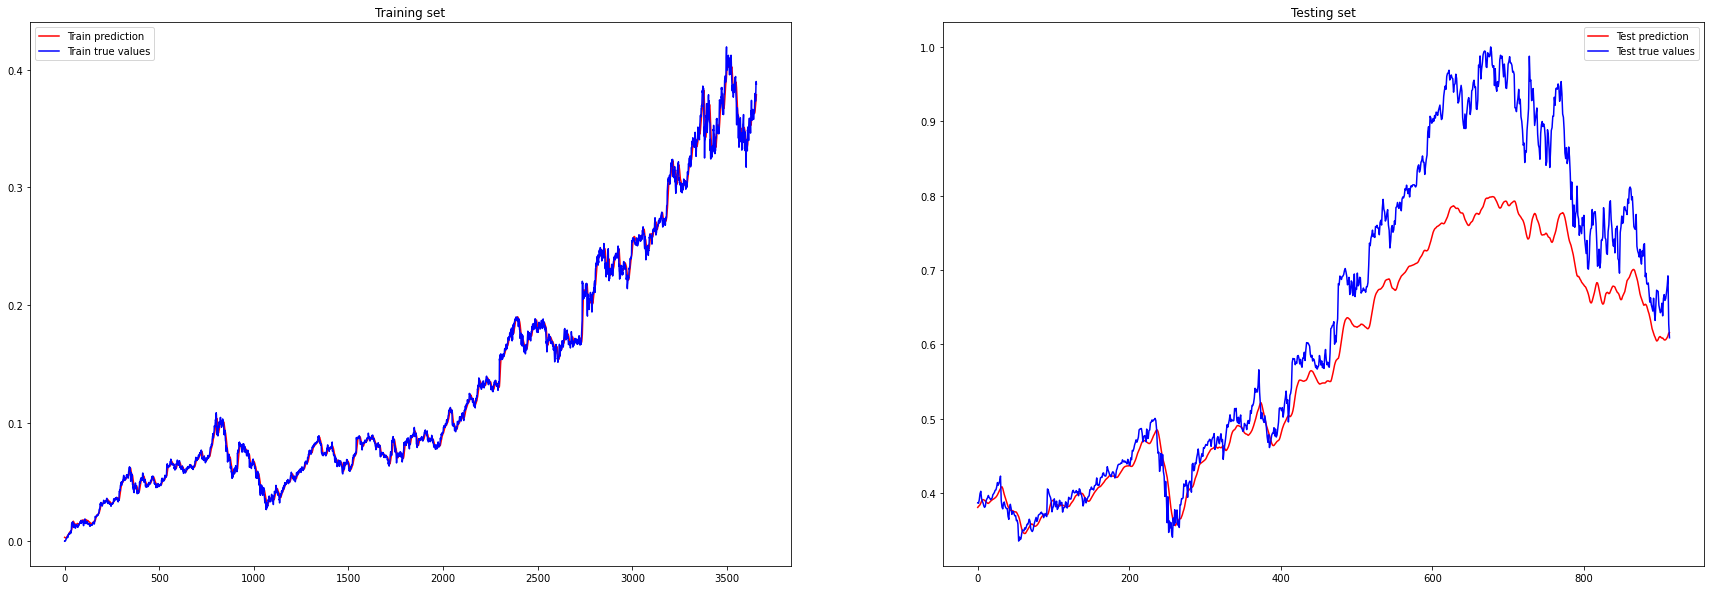

In [37]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current gru model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_gru = GRUnet(input_size, hs, nl)   
        trained_gru_test, test_gru_loss = train_model(test_gru, verbose=0)
        plot_prediction(trained_gru_test)
        print()

In [46]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    X_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    X_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    
    return [X_train, y_train, X_test, y_test]

look_back = 30 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df[["Close"]], look_back)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape = (3641, 29, 1)
y_train.shape = (3641, 1)
x_test.shape = (910, 29, 1)
y_test.shape = (910, 1)


In [47]:
best_rnn = RNNnet(1, 32, 1)
best_lstm = LSTMnet(1, 128, 1)
best_gru = GRUnet(1, 64, 1)

In [49]:
best_rnn, best_rnn_loss = train_model(best_rnn)

Epoch: 10 MSE: 0.0061402046121656895
Epoch: 20 MSE: 0.0015296109486371279
Epoch: 30 MSE: 0.00047923470265232027
Epoch: 40 MSE: 0.0002808135177474469
Epoch: 50 MSE: 8.646990318084136e-05
Epoch: 60 MSE: 2.1586987713817507e-05
Epoch: 70 MSE: 1.074537340173265e-05
Epoch: 80 MSE: 1.1986027857346926e-05
Epoch: 90 MSE: 1.1381872354832012e-05
Epoch: 100 MSE: 1.0093377568409778e-05
Epoch: 110 MSE: 1.019373485178221e-05
Epoch: 120 MSE: 1.0007312084781006e-05
Epoch: 130 MSE: 1.0010418918682262e-05
Epoch: 140 MSE: 9.990481885324698e-06
Epoch: 150 MSE: 9.979034985008184e-06
Epoch: 160 MSE: 9.972932275559288e-06
Epoch: 170 MSE: 9.96628477878403e-06
Epoch: 180 MSE: 9.959339877241291e-06
Epoch: 190 MSE: 9.952354957931675e-06


Train Score: 1.00 RMSE
Test Score: 5.57 RMSE


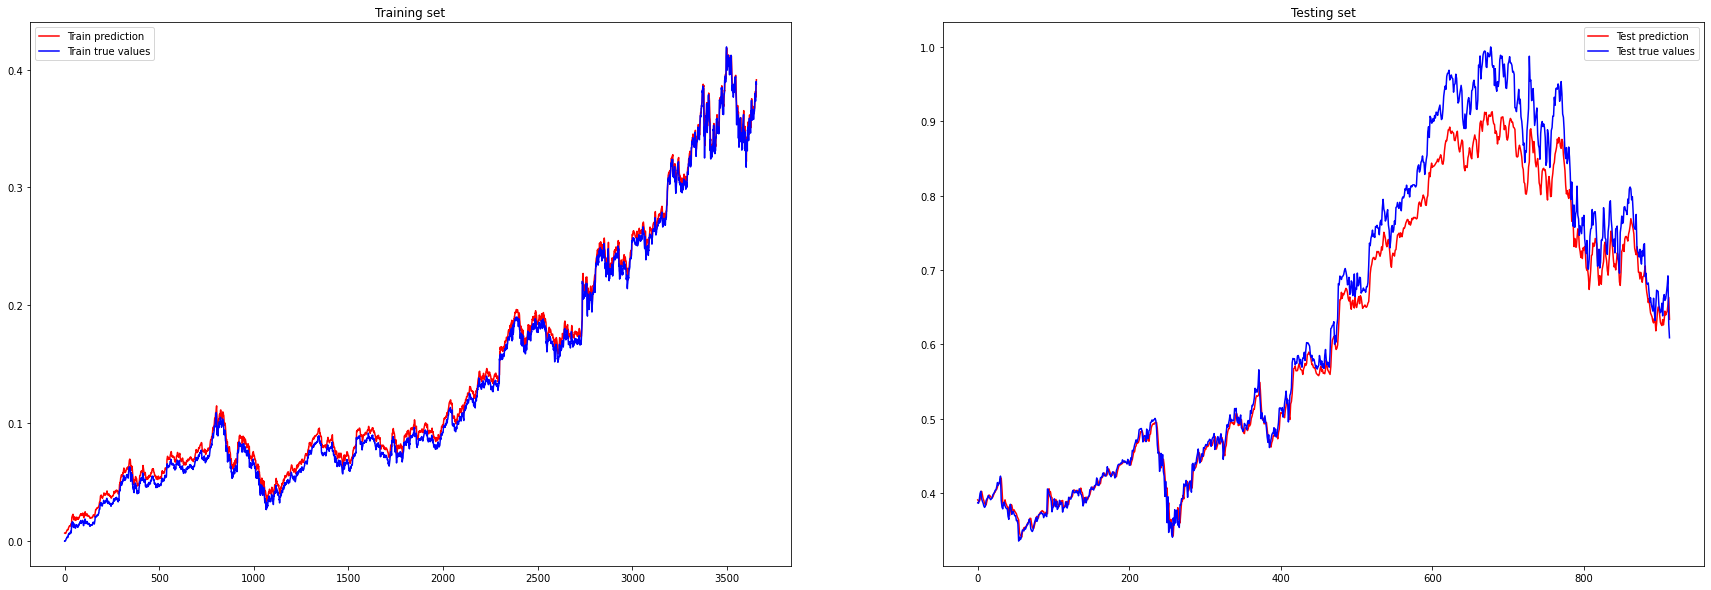

In [50]:
plot_prediction(best_rnn)

In [53]:
best_lstm, best_lstm_loss = train_model(best_lstm)

Epoch: 10 MSE: 0.010016060434281826
Epoch: 20 MSE: 0.005822567734867334
Epoch: 30 MSE: 0.011332599446177483
Epoch: 40 MSE: 0.006739609409123659
Epoch: 50 MSE: 0.0038528884761035442
Epoch: 60 MSE: 0.0014843818498775363
Epoch: 70 MSE: 0.00019598841026891023
Epoch: 80 MSE: 0.00012460091966204345
Epoch: 90 MSE: 4.839485700358637e-05
Epoch: 100 MSE: 1.879320370790083e-05
Epoch: 110 MSE: 1.7470967577537522e-05
Epoch: 120 MSE: 1.2843141121265944e-05
Epoch: 130 MSE: 1.2690789844782557e-05
Epoch: 140 MSE: 1.2091065400454681e-05
Epoch: 150 MSE: 1.2025018804706633e-05
Epoch: 160 MSE: 1.1968570106546395e-05
Epoch: 170 MSE: 1.1931081644434016e-05
Epoch: 180 MSE: 1.1916289622604381e-05
Epoch: 190 MSE: 1.1906357030966319e-05


Train Score: 0.52 RMSE
Test Score: 4.63 RMSE


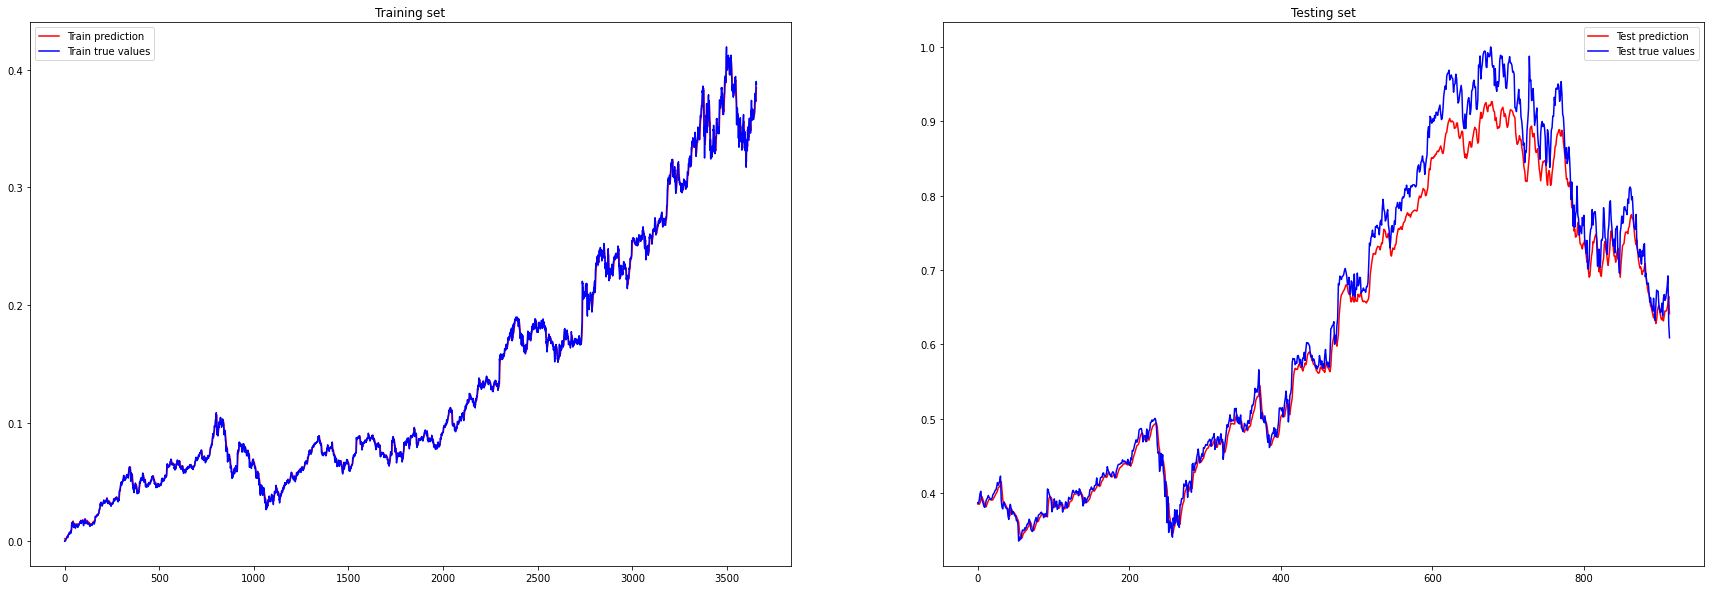

In [54]:
plot_prediction(best_lstm)

In [55]:
best_gru, best_gru_loss = train_model(best_gru)

Epoch: 10 MSE: 0.001440143445506692
Epoch: 20 MSE: 5.41159970453009e-05
Epoch: 30 MSE: 7.34851710149087e-05
Epoch: 40 MSE: 3.774002834688872e-05
Epoch: 50 MSE: 2.85361529677175e-05
Epoch: 60 MSE: 2.047593443421647e-05
Epoch: 70 MSE: 1.3327327906154096e-05
Epoch: 80 MSE: 9.33583032747265e-06
Epoch: 90 MSE: 9.144562682195101e-06
Epoch: 100 MSE: 9.064596270036418e-06
Epoch: 110 MSE: 8.870832971297204e-06
Epoch: 120 MSE: 8.841274393489584e-06
Epoch: 130 MSE: 8.79520575836068e-06
Epoch: 140 MSE: 8.759505362831987e-06
Epoch: 150 MSE: 8.732890819374006e-06
Epoch: 160 MSE: 8.707619599590544e-06
Epoch: 170 MSE: 8.684552994964179e-06
Epoch: 180 MSE: 8.663566404720768e-06
Epoch: 190 MSE: 8.644261470180936e-06


Train Score: 0.43 RMSE
Test Score: 2.51 RMSE


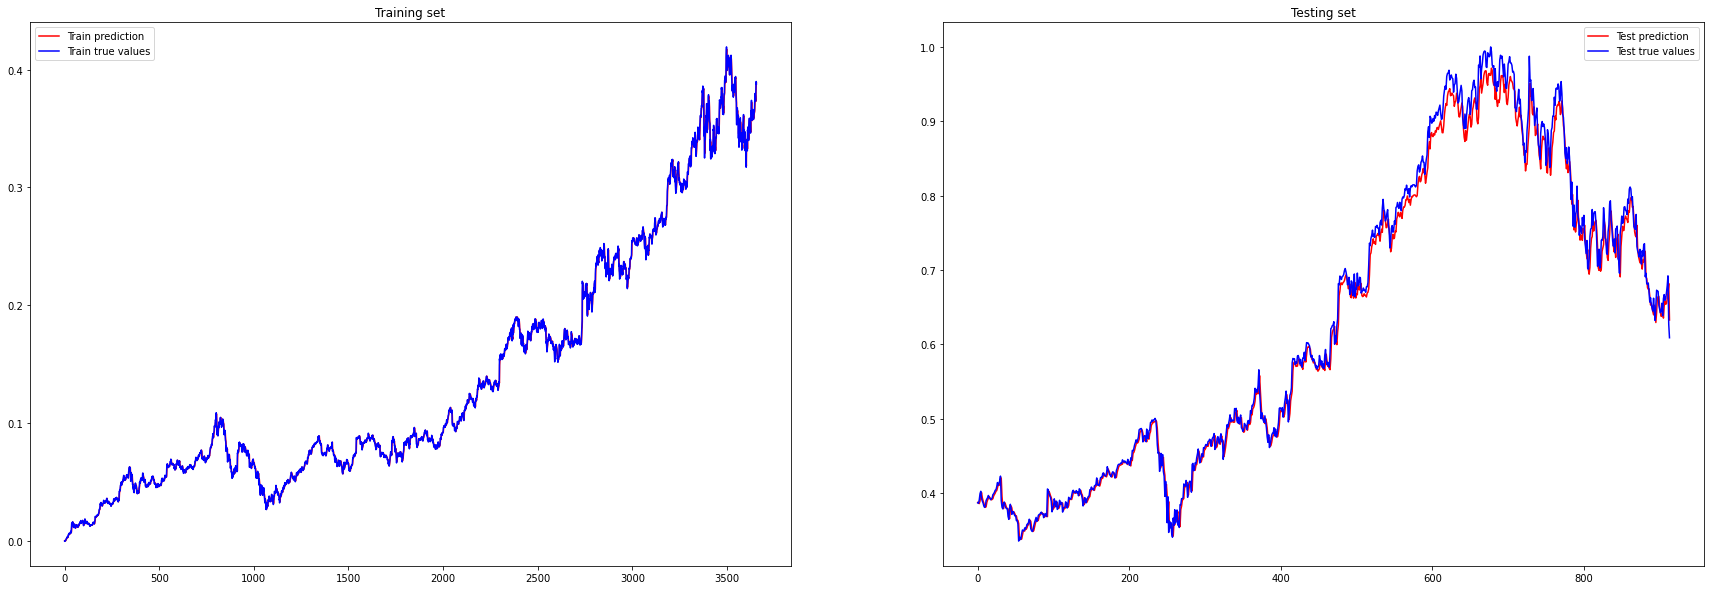

In [56]:
plot_prediction(best_gru)